# Conducting Between Analysis Between Region

Here we conduct physical analysis between basins.

1) We download a handful of floats into a parquet and estimate potential density and calculate MLD

2) Expansion into a larger dataset, Here we expand nº1 into a larger dataset and seperating into regions

# Expanded Dataset
Analysis and parameters were developed based on studies Tanner et al. (2024) Shoeman, Erbe & McCauley 2024

# Download Expanded dataset
Here we download all profiles within region since 2014. Download are stored as Regional_Argo_Tablet.parquet. 

In [2]:
# Immporting Labriaries
# If not available, install using pip install <package-name>

# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import cmocean
import polars as pl
# Libraries for data handling

import polars as pl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Library for estimating oceanographic parameters
import gsw

# Library for downloading data

import os
from pathlib import Path
import argopy
from argopy import DataFetcher

## Argopy bypass attempt

In [2]:
root = '../data/argo'
profile_dir = root + '/Profiles/'

In [ ]:
# Function to download a single file
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [ ]:
# Function to download and parse GDAC synthetic profile index file
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (<list of WMOIDs>, <DataFrame of index file subset>,
                                                            <list of downloaded filenames [if applicable]>)
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

In [ ]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=[55,67],lon_range=[-44,-10],
                               start_date=None,end_date=None,
                               sensors=None,floats=None,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> Successfully downloaded argo_synthetic-profile_index.txt.


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_5207/3441803214.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


>>> Successfully downloaded 1902304_Sprof.nc.
>>> Successfully downloaded 3902258_Sprof.nc.
>>> Successfully downloaded 3902259_Sprof.nc.
>>> Successfully downloaded 3902260_Sprof.nc.
>>> Successfully downloaded 3902261_Sprof.nc.
>>> Successfully downloaded 3902333_Sprof.nc.
>>> Successfully downloaded 4903365_Sprof.nc.
>>> Successfully downloaded 4903488_Sprof.nc.
>>> Successfully downloaded 4903532_Sprof.nc.
>>> Successfully downloaded 3901581_Sprof.nc.
>>> Successfully downloaded 3901586_Sprof.nc.
>>> Successfully downloaded 3902681_Sprof.nc.
>>> Successfully downloaded 6901180_Sprof.nc.
>>> Successfully downloaded 6901933_Sprof.nc.
>>> Successfully downloaded 6904185_Sprof.nc.
>>> Successfully downloaded 1901209_Sprof.nc.
>>> Successfully downloaded 1901210_Sprof.nc.
>>> Successfully downloaded 1901211_Sprof.nc.
>>> Successfully downloaded 1901214_Sprof.nc.
>>> Successfully downloaded 1901215_Sprof.nc.
>>> Successfully downloaded 1901217_Sprof.nc.
>>> Successfully downloaded 190262

In [ ]:
# Load downloaded profiles into xarray Dataset
fn = sorted(Path(profile_dir).glob("*_Sprof.nc"))[0]
ds = xr.open_dataset(fn)

print("FILE:", fn.name)
print("\n--- DATASET SUMMARY ---")
print(ds)

print("\n--- DIMS ---")
print(ds.dims)

print("\n--- COORDS ---")
print(list(ds.coords))

print("\n--- DATA VARIABLES (first 50) ---")
print(list(ds.data_vars)[:50])

FILE: 1901209_Sprof.nc

--- DATASET SUMMARY ---
<xarray.Dataset> Size: 389kB
Dimensions:                       (N_PROF: 25, N_PARAM: 4, N_CALIB: 2,
                                   N_LEVELS: 121)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/58)
    DATA_TYPE                     object 8B ...
    FORMAT_VERSION                object 8B ...
    HANDBOOK_VERSION              object 8B ...
    REFERENCE_DATE_TIME           object 8B ...
    DATE_CREATION                 object 8B ...
    DATE_UPDATE                   object 8B ...
    ...                            ...
    DOXY                          (N_PROF, N_LEVELS) float32 12kB ...
    DOXY_QC                       (N_PROF, N_LEVELS) object 24kB ...
    DOXY_dPRES                    (N_PROF, N_LEVELS) float32 12kB ...
    DOXY_ADJUSTED                 (N_PROF, N_LEVELS) float32 12kB ...
    DOXY_ADJUSTED_QC              (N_PROF, N_LEVELS) object 24kB ...
    DOXY_ADJUSTED_ERROR           (N

In [ ]:
from pathlib import Path
import numpy as np
import xarray as xr
import polars as pl

in_dir = Path(profile_dir)
out_parquet = in_dir / "argo_sprof_flat.parquet"

# --- helpers -------------------------------------------------

def _as_str1(x):
    """Convert xarray object/bytes scalars to python str (safe)."""
    if x is None:
        return None
    if hasattr(x, "dtype") and x.dtype.kind in ("S", "U", "O"):
        # x could be 0-d or array; we handle element-wise elsewhere
        pass
    if isinstance(x, (bytes, np.bytes_)):
        return x.decode("utf-8", errors="ignore").strip()
    return str(x).strip()

def _obj_array_to_utf8(a: np.ndarray) -> np.ndarray:
    """Convert object/bytes array to str array; keep None for missing."""
    out = np.empty(a.shape, dtype=object)
    it = np.nditer(a, flags=["multi_index", "refs_ok"], op_flags=["readonly"])
    for v in it:
        vv = v.item()
        if vv is None:
            out[it.multi_index] = None
        elif isinstance(vv, (bytes, np.bytes_)):
            out[it.multi_index] = vv.decode("utf-8", errors="ignore").strip()
        else:
            out[it.multi_index] = str(vv).strip()
    return out

def _get_1d(ds, name, nprof):
    """Return 1D array (N_PROF,) for variable name, or None."""
    if name not in ds:
        return None
    v = ds[name].values
    # Many profile vars are (N_PROF,) already
    if v.ndim == 1 and v.shape[0] == nprof:
        if v.dtype == object:
            v = _obj_array_to_utf8(v)
        return v
    # Some are (N_PROF, something) like JULD_LOCATION; ignore by default
    return None

def _get_2d(ds, name, nprof, nlev):
    """Return 2D array (N_PROF,N_LEVELS) for variable name, or None."""
    if name not in ds:
        return None
    v = ds[name].values
    if v.ndim == 2 and v.shape == (nprof, nlev):
        if v.dtype == object:
            v = _obj_array_to_utf8(v)
        return v
    return None

# Choose what to include:
PROFILE_VARS = [
    "PLATFORM_NUMBER", "CYCLE_NUMBER", "DIRECTION",
    "JULD", "LATITUDE", "LONGITUDE",
    "POSITION_QC", "JULD_QC", "CHLA", "CHLA_ADJUSTED",
    "CHLA_QC", "CHLA_ADJUSTED_QC",
    "DOWNWELLING_PAR", "DOWNWELLING_PAR_ADJUSTED",
    "DOWNWELLING_PAR_QC", "DOWNWELLING_PAR_ADJUSTED_QC"
]
# Include all 2D measurement vars automatically except obvious metadata
EXCLUDE_2D_PREFIX = {
    "SCIENTIFIC_CALIB_", "PROFILE_", "STATION_PARAMETERS", "PARAMETER",
}
EXCLUDE_EXACT = {
    "DATA_TYPE","FORMAT_VERSION","HANDBOOK_VERSION","REFERENCE_DATE_TIME",
    "DATE_CREATION","DATE_UPDATE","PROJECT_NAME","PI_NAME","DATA_CENTRE",
    "PLATFORM_TYPE","FLOAT_SERIAL_NO","FIRMWARE_VERSION","WMO_INST_TYPE",
    "PARAMETER_DATA_MODE","CONFIG_MISSION_NUMBER","POSITIONING_SYSTEM",
    "JULD_LOCATION",  
}

def flatten_one_file(nc_path: Path) -> pl.DataFrame:
    ds = xr.open_dataset(nc_path, decode_cf=True)

    nprof = int(ds.dims["N_PROF"])
    nlev  = int(ds.dims["N_LEVELS"])

    # Level & profile indices for joins/debugging
    prof_idx = np.repeat(np.arange(nprof, dtype=np.int32), nlev)
    lev_idx  = np.tile(np.arange(nlev, dtype=np.int32), nprof)

    cols = {
        "source_file": np.repeat(nc_path.name, nprof * nlev),
        "prof_index": prof_idx,
        "level_index": lev_idx,
    }

    # Profile vars repeated to levels
    for vname in PROFILE_VARS:
        v = _get_1d(ds, vname, nprof)
        if v is not None:
            cols[vname] = np.repeat(v, nlev)

    # All 2D measurement vars
    for vname in list(ds.data_vars):
        if vname in cols or vname in EXCLUDE_EXACT:
            continue
        if any(vname.startswith(pfx) for pfx in EXCLUDE_2D_PREFIX):
            continue
        v2 = _get_2d(ds, vname, nprof, nlev)
        if v2 is None:
            continue
        cols[vname] = v2.reshape(-1)

    ds.close()

    # Build Polars DF
    df = pl.DataFrame(cols)

    # Optional: cast QC columns to categorical (saves space)
    #qc_cols = [c for c in df.columns if c.endswith("_QC") or c in ("POSITION_QC","JULD_QC")]
    #if qc_cols:
    #    df = df.with_columns([pl.col(c).cast(pl.Categorical) for c in qc_cols if c in df.columns])

    ## Optional: cast PLATFORM_NUMBER, DIRECTION to categorical
    #for c in ["PLATFORM_NUMBER","DIRECTION"]:
    #    if c in df.columns:
    #        df = df.with_columns(pl.col(c).cast(pl.Categorical))

    return df

# --- main: stream-write into ONE parquet ----------------------

files = sorted(in_dir.glob("*_Sprof.nc"))
if not files:
    raise FileNotFoundError(f"No *_Sprof.nc found in {in_dir}")

# Use a sink (streaming) so you don’t hold everything in memory
lazy_frames = [flatten_one_file(f).lazy() for f in files]
big = pl.concat(lazy_frames, how="diagonal_relaxed")

# Write one parquet file
big.sink_parquet(out_parquet, compression="zstd")
print("Wrote:", out_parquet)

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_7314/1237875447.py:84: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nprof = int(ds.dims["N_PROF"])
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_7314/1237875447.py:85: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlev  = int(ds.dims["N_LEVELS"])
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_7314/1237875447.py:84: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dime

Wrote: ../data/argo/Profiles/argo_sprof_flat.parquet


In [3]:
in_path = "../data/argo/Profiles/argo_sprof_flat.parquet"
out_path = "../data/argo/Profiles/argo_sprof_flat_pd.parquet"

lf = (
    pl.scan_parquet(in_path)

    # keep rows where at least one variable exists
    .filter(
        pl.col("DOWNWELLING_PAR").is_not_null() |
        pl.col("CHLA_ADJUSTED").is_not_null()
    )

    # create TIME from JULD
    .with_columns(
        pl.col("JULD").alias("TIME")
    )

    # convert ALL categoricals → Utf8 (lazy, zero-copy until collect)
    .with_columns(
        pl.col(pl.Categorical).cast(pl.Utf8)
    )
)

# write directly from lazy frame (no giant in-memory df)
lf.sink_parquet(out_path)

In [ ]:
df = pl.scan_parquet("../data/argo/Profiles/argo_sprof_flat.parquet")

# convert categoricals to strings so pandas won't choke later
df = df.with_columns([
    pl.col(pl.Categorical).cast(pl.Utf8)
])

df = df.with_columns(
    pl.col("JULD").alias("TIME")
)

df.write_parquet("../data/argo/Profiles/argo_sprof_flat_pd.parquet")

## Tagging system

In [4]:

from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

# Pacakages for data handling
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
import polars as pl
import os
from pathlib import Path
from shapely.geometry import Point, Polygon
xr.set_options(display_expand_attrs = False)

In [5]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

In [6]:
# -*- coding: utf-8 -*-
"""
Apply two custom geographic regions to parquet datasets using exact polygons.
Adds a 'region' column with values:
    'irminger', 'icelandic', or 'Other'
"""

from pathlib import Path
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon


# -------------------------------------------------------
# REGION POLYGONS (EXACT SHAPES)
# -------------------------------------------------------

irminger_vertices = [
    (-44, 66),
    (-24, 66),
    (-24, 64),
    (-35, 55),
    (-44, 55)
]
irminger_poly = Polygon(irminger_vertices)

# Vertices in (lon, lat) order
icelandic_vertices = [
    (-24, 64),   # 1
    (-10, 64),   # 2
    (-20, 55),   # 3
    (-35, 55)   # 4
]
icelandic_poly = Polygon(icelandic_vertices)


# -------------------------------------------------------
# GLOBAL CONFIG
# -------------------------------------------------------

USE_DEEP_OCEAN_MASK = False
ETOPO1_PATH = Path("../data/etopo1_subset.nc")

PARQUETS = [
    #Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    #Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet"),
    Path("../data/argo/Profiles/argo_sprof_flat_pd.parquet")
]

COL_LON = "LONGITUDE"
COL_LAT = "LATITUDE"

OVERLAP_PRECEDENCE = "shape2_over_shape1"   # icelandic overrides irminger


# -------------------------------------------------------
# HELPERS
# -------------------------------------------------------

def to_minus180_180(lon):
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0


def load_etopo(path):
    import xarray as xr
    if not path.exists():
        print(f"[WARN] ETOPO file not found at {path}. Deep-ocean mask skipped.")
        return None
    ds = xr.open_dataset(path)
    for k in ("z", "longitude", "latitude"):
        if k not in ds:
            raise ValueError("ETOPO dataset must include variables: z, longitude, latitude")
    return ds


def deep_mask_from_etopo(ds, lonp, latp, thresh=-1000.0):
    zi = ds["z"].interp(longitude=(["p"], lonp), latitude=(["p"], latp)).values
    return zi <= float(thresh)


# -------------------------------------------------------
# POLYGON-BASED SHAPE CLASSIFICATION
# -------------------------------------------------------

def classify_shapes(lonp, latp):
    points = [Point(lonp[i], latp[i]) for i in range(len(lonp))]

    in_irminger  = np.array([irminger_poly.contains(pt) for pt in points])
    in_icelandic = np.array([icelandic_poly.contains(pt) for pt in points])

    debug = {
        "irminger_vertices": irminger_vertices,
        "icelandic_vertices": icelandic_vertices,
        "irminger_count": int(in_irminger.sum()),
        "icelandic_count": int(in_icelandic.sum()),
    }

    return in_irminger, in_icelandic, debug


# -------------------------------------------------------
# LABEL ASSIGNMENT (IRINGER / ICELANDIC / OTHER)
# -------------------------------------------------------

def assign_labels(in1, in2, precedence="icelandic_over_irminger"):
    labels = np.full(len(in1), "Other", dtype=object)

    if precedence == "icelandic_over_irminger":
        labels[in1] = "irminger"
        labels[in2] = "icelandic"    # overrides overlaps
    else:
        labels[in2] = "icelandic"
        labels[in1] = "irminger"

    return labels


# -------------------------------------------------------
# PROCESS ONE PARQUET
# -------------------------------------------------------

def process_one(parquet_path, ds_etopo=None, use_deep=False):
    print(f"\n======== Processing: {parquet_path.name} ========")

    if not parquet_path.exists():
        print(f"[WARN] Missing parquet: {parquet_path} (skipped)")
        return

    df = pd.read_parquet(parquet_path).copy()

    if COL_LON not in df or COL_LAT not in df:
        raise KeyError(f"Expected columns '{COL_LON}' and '{COL_LAT}' in {parquet_path}")

    LON_raw = df[COL_LON].astype(float).to_numpy()
    LAT     = df[COL_LAT].astype(float).to_numpy()
    LON     = to_minus180_180(LON_raw)

    print(f"Lon raw range: {np.nanmin(LON_raw):.3f} → {np.nanmax(LON_raw):.3f}")
    print(f"Lon norm range: {np.nanmin(LON):.3f} → {np.nanmax(LON):.3f}")
    print(f"Lat range:      {np.nanmin(LAT):.3f} → {np.nanmax(LAT):.3f}")
    print(f"N rows:         {len(df)}")

    # Polygon classification
    in_irminger, in_icelandic, dbg = classify_shapes(LON, LAT)

    print("\n-- Irminger region --")
    print("Vertices:", dbg["irminger_vertices"])
    print("Points in region:", dbg["irminger_count"])

    print("\n-- Icelandic region --")
    print("Vertices:", dbg["icelandic_vertices"])
    print("Points in region:", dbg["icelandic_count"])

    # Deep-ocean mask
    if use_deep:
        if ds_etopo is None:
            raise RuntimeError("USE_DEEP_OCEAN_MASK=True but no ETOPO dataset loaded.")
        deep = deep_mask_from_etopo(ds_etopo, LON, LAT, thresh=-1000.0)
        in_irminger &= deep
        in_icelandic &= deep

    # Assign region names
    labels = assign_labels(in_irminger, in_icelandic, precedence=OVERLAP_PRECEDENCE)
    df["region"] = labels

    # Save result
    df.to_parquet(parquet_path, index=False)
    print("\nWrote:", parquet_path)
    print("Region counts:\n", df["region"].value_counts(dropna=False).to_string())


# -------------------------------------------------------
# MAIN
# -------------------------------------------------------

def main():
    ds = load_etopo(ETOPO1_PATH) if USE_DEEP_OCEAN_MASK else None
    for pq in PARQUETS:
        process_one(pq, ds_etopo=ds, use_deep=USE_DEEP_OCEAN_MASK)

if __name__ == "__main__":
    main()


======== Processing: argo_sprof_flat_pd.parquet ========
Lon raw range: -67.817 → 12.233
Lon norm range: -67.817 → 12.233
Lat range:      44.836 → 77.137
N rows:         18243378

-- Irminger region --
Vertices: [(-44, 66), (-24, 66), (-24, 64), (-35, 55), (-44, 55)]
Points in region: 4549640

-- Icelandic region --
Vertices: [(-24, 64), (-10, 64), (-20, 55), (-35, 55)]
Points in region: 3847753

Wrote: ../data/argo/Profiles/argo_sprof_flat_pd.parquet
Region counts:
 region
Other        9845985
irminger     4549640
icelandic    3847753



===== argo_sprof_flat_pd.parquet =====
TIME range: 2013-04-17 20:49:00 → 2026-01-11 03:04:58.000327168


,region,year,month,profile_count
0,Other,2013,5,39
1,Other,2013,6,62
2,Other,2013,7,45
3,Other,2013,8,18
4,Other,2013,9,18
5,Other,2013,10,9
6,Other,2013,11,12
7,Other,2013,12,15
8,Other,2014,1,19
9,Other,2014,2,34


,region,year,week,profile_count
0,Other,2013,20,15
1,Other,2013,21,14
2,Other,2013,22,11
3,Other,2013,23,20
4,Other,2013,24,11
5,Other,2013,25,18
6,Other,2013,26,12
7,Other,2013,27,9
8,Other,2013,28,17
9,Other,2013,29,7


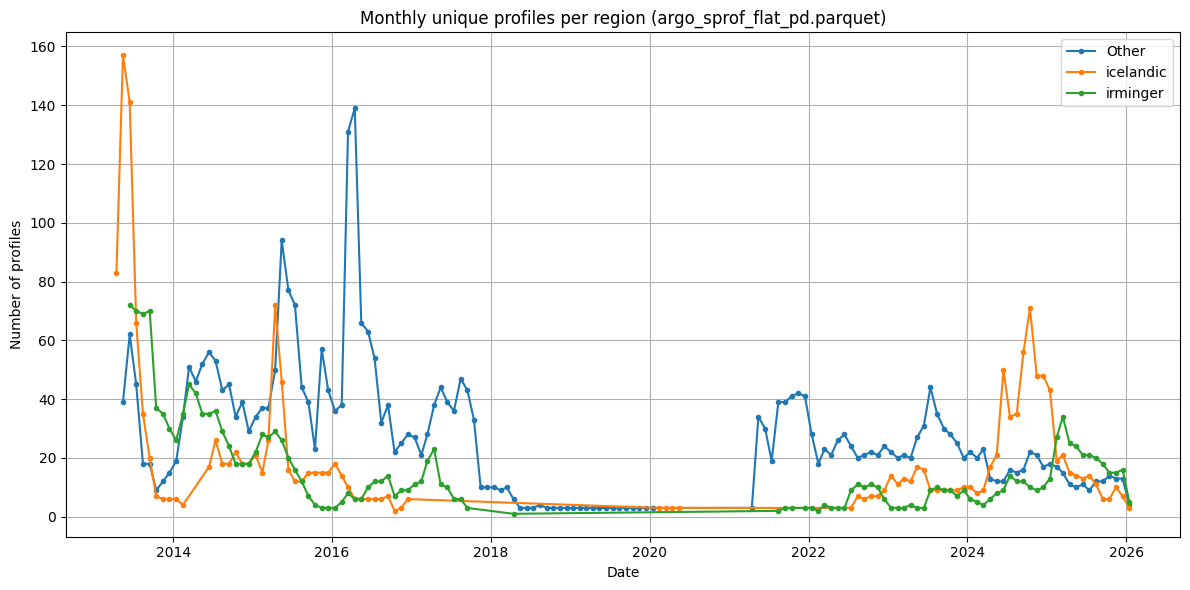

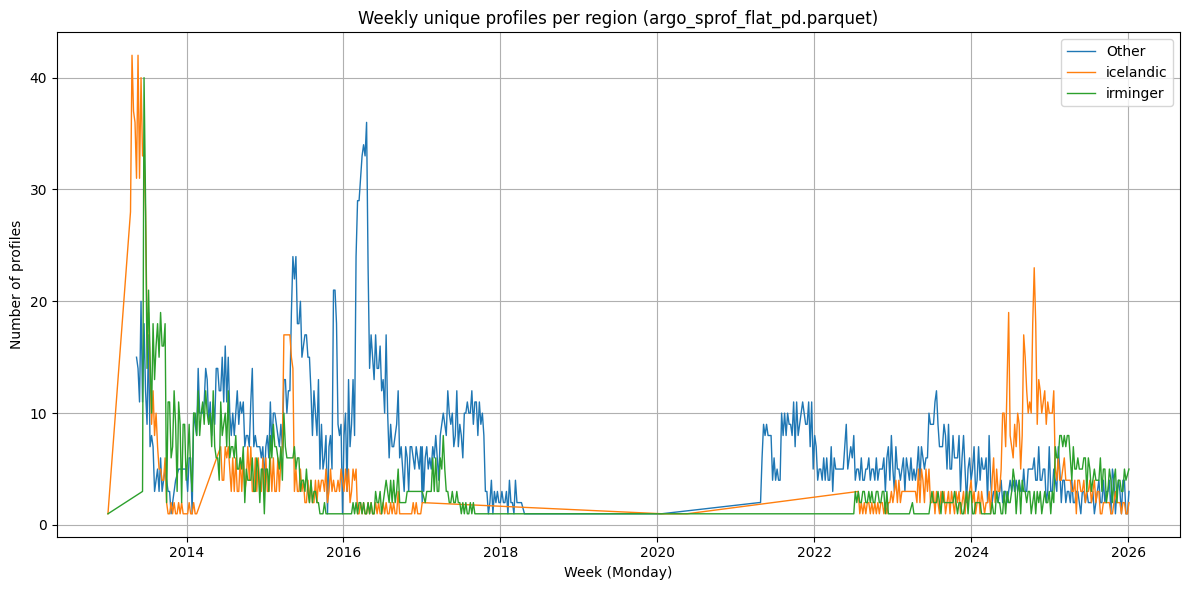

<Figure size 1200x600 with 0 Axes>

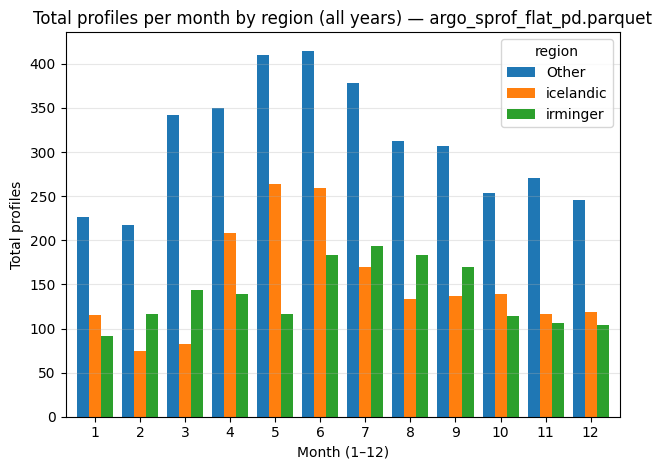

<Figure size 1200x600 with 0 Axes>

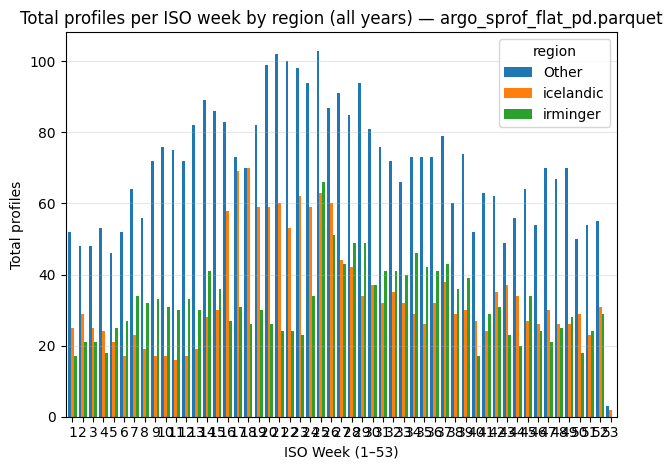

In [7]:
# --- Quick check: number of unique profiles per region for BOTH datasets ---

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Files to analyze
parquets = [
    #Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    #Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet"),
    Path("../data/argo/Profiles/argo_sprof_flat_pd.parquet")
]

# Columns (adjust if needed)
COL_TIME = "TIME"
COL_PLATFORM = "PLATFORM_NUMBER"
COL_CYCLE = "CYCLE_NUMBER"
COL_REGION = "region"

for parquet_path in parquets:
    print(f"\n===== {parquet_path.name} =====")
    df = pd.read_parquet(parquet_path)

    # --- Parse datetime ---
    df[COL_TIME] = pd.to_datetime(df[COL_TIME], errors="coerce", utc=True).dt.tz_convert(None)
    print("TIME range:", df[COL_TIME].min(), "→", df[COL_TIME].max())

    # --- Each (platform, cycle, region) = one profile ---
    profiles = df.drop_duplicates(subset=[COL_PLATFORM, COL_CYCLE, COL_REGION]).copy()

    # --- Extract year / month / ISO week ---
    profiles["year"] = profiles[COL_TIME].dt.year
    profiles["month"] = profiles[COL_TIME].dt.month
    profiles["week"] = profiles[COL_TIME].dt.isocalendar().week.astype(int)

    # --- Count profiles per region ---
    monthly_counts = (
        profiles.groupby(["region", "year", "month"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "month"])
    )

    weekly_counts = (
        profiles.groupby(["region", "year", "week"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "week"])
    )

    display(monthly_counts.head(10))
    display(weekly_counts.head(10))

    # --- Monthly plot ---
    plt.figure(figsize=(12, 6))
    for region, group in monthly_counts.groupby("region", dropna=False):
        # Plot at mid-month
        dates = pd.to_datetime(group["year"].astype(str) + "-" + group["month"].astype(str) + "-15")
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], marker="o", ms=3, label=label)
    plt.title(f"Monthly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Date")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Weekly plot ---
    plt.figure(figsize=(12, 6))
    for region, group in weekly_counts.groupby("region", dropna=False):
        # Monday of the ISO week
        dates = pd.to_datetime(
            group["year"].astype(str) + "-W" + group["week"].astype(str) + "-1",
            format="%G-W%V-%u",
        )
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], linewidth=1, label=label)
    plt.title(f"Weekly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Week (Monday)")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()   
    
     # --- Total profiles per calendar month, broken down by region ---
    monthly_region_totals = (
        monthly_counts
        .groupby(["region", "month"])["profile_count"]
        .sum()
        .reset_index()
        .pivot(index="month", columns="region", values="profile_count")
        .fillna(0)
        .sort_index()
    )

    plt.figure(figsize=(12, 6))
    monthly_region_totals.plot(kind="bar", width=0.8)
    plt.title(f"Total profiles per month by region (all years) — {parquet_path.name}")
    plt.xlabel("Month (1–12)")
    plt.ylabel("Total profiles")
    plt.xticks(rotation=0)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

        # --- Total profiles per ISO week, broken down by region ---
    weekly_region_totals = (
        weekly_counts
        .groupby(["region", "week"])["profile_count"]
        .sum()
        .reset_index()
        .pivot(index="week", columns="region", values="profile_count")
        .fillna(0)
        .sort_index()
    )

    plt.figure(figsize=(12, 6))
    weekly_region_totals.plot(kind="bar", width=0.8)
    plt.title(f"Total profiles per ISO week by region (all years) — {parquet_path.name}")
    plt.xlabel("ISO Week (1–53)")
    plt.ylabel("Total profiles")
    plt.xticks(rotation=0)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


Plotting positions for: argo_sprof_flat_pd.parquet


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:483: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packag

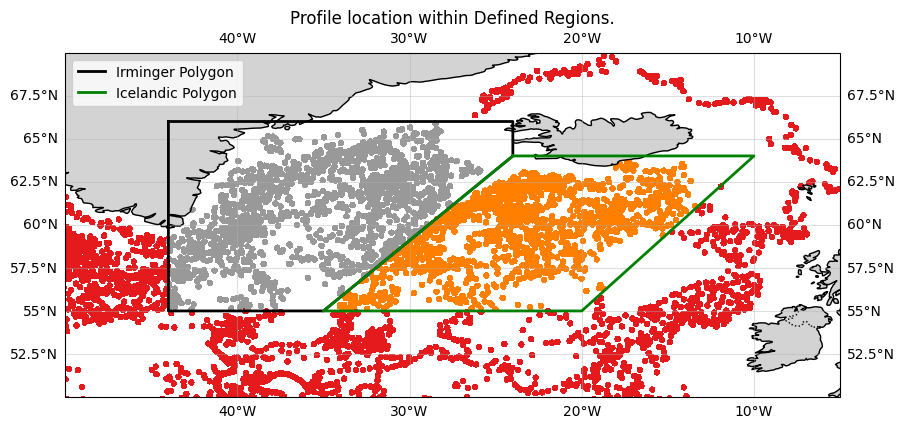

: 

In [ ]:
# Plotting the location of the floats
# -------------------------------------------------------
# PLOT PROFILE LOCATIONS WITH REGION POLYGONS
# -------------------------------------------------------

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reload DataFrame (already includes region labels)
for parquet_path in parquets:
    print(f"\nPlotting positions for: {parquet_path.name}")
    df = pd.read_parquet(parquet_path)

    # Normalise longitude
    lon = ((df["LONGITUDE"] + 180) % 360) - 180
    lat = df["LATITUDE"]

    # Setup figure
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Map extent (adjust if needed)
    ax.set_extent([-50, -5, 50, 70], crs=ccrs.PlateCarree())

    # Add base features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.gridlines(draw_labels=True, alpha=0.4)

    # --- Plot the profile points ---
    scatter = ax.scatter(
        lon,
        lat,
        c=df["region"].astype("category").cat.codes,
        s=8,
        alpha=0.7,
        cmap="Set1",
        transform=ccrs.PlateCarree(),
    )

    # --- Plot the two polygons (region boundaries) ---
    irm_lons, irm_lats = zip(*irminger_vertices)
    ax.plot(irm_lons + (irm_lons[0],),
            irm_lats + (irm_lats[0],),
            "-k", lw=2, label="Irminger Polygon")

    ice_lons, ice_lats = zip(*icelandic_vertices)
    ax.plot(ice_lons + (ice_lons[0],),
            ice_lats + (ice_lats[0],),
            "-g", lw=2, label="Icelandic Polygon")

    # --- Legend ---
    plt.title(f"Profile location within Defined Regions.")
    plt.legend()
    plt.show()

# Argo Analysis

## Physical Parameters

MLD Was estiamted using gsw and Adjusted values. MLD time series was also developed, values were averaged weekly (atleast at first) 

In [147]:
import polars as pl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
import gsw



#### Producing MLD

In [148]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL_ADJUSTED"].to_numpy()
    t   = df["TEMP_ADJUSTED"].to_numpy()
    p   = df["PRES_ADJUSTED"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [149]:
# Fetching data from Parquet.
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

# Filtering data below 500m
#df = df.filter(pl.col('PRES') < 1000)

# EStimating MLD

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing MLD per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME,region,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns],str,f64,f64
1,311,"""D""","""A""",4901404,1,2.5,2.5,2.4,1,1,34.861,34.860989,0.01,1,1,11.005,11.005,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.670154,18.0
1,311,"""D""","""A""",4901404,1,4.0,4.0,2.4,1,1,34.861,34.860958,0.01,1,1,11.005,11.005,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.670158,18.0
1,311,"""D""","""A""",4901404,1,6.0,6.0,2.4,1,1,34.861,34.861019,0.01,1,1,11.006,11.006,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.670062,18.0
1,311,"""D""","""A""",4901404,1,8.0,8.0,2.4,1,1,34.861,34.861382,0.01001,1,1,11.006,11.006,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.670382,18.0
1,311,"""D""","""A""",4901404,1,10.0,10.0,2.4,1,1,34.860001,34.860222,0.01,1,1,10.997,10.997,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.671143,18.0


#### Creating Time MLD time series 
Time series was created by using weekly averages and linear interporlation for each Region

In [150]:

# --- Separating Regions ---
irminger = df.filter(pl.col('region') == 'irminger').to_pandas()
icelandic = df.filter(pl.col('region') == 'icelandic').to_pandas()

# --- One row per (platform, cycle) profile ---
irminger = irminger.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()
icelandic = icelandic.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()

# --- TIME to datetime ---
irminger["TIME"] = pd.to_datetime(irminger["TIME"])
icelandic["TIME"] = pd.to_datetime(icelandic["TIME"])

# --- ISO year/week ---
irminger["year"]     = irminger["TIME"].dt.isocalendar().year.astype(int)
irminger["iso_week"] = irminger["TIME"].dt.isocalendar().week.astype(int)
irminger["month"]    = irminger["TIME"].dt.month

icelandic["year"]     = icelandic["TIME"].dt.isocalendar().year.astype(int)
icelandic["iso_week"] = icelandic["TIME"].dt.isocalendar().week.astype(int)
icelandic["month"]    = icelandic["TIME"].dt.month

# --- Weekly mean + range (min/max) ---
weekly1 = (
    irminger.groupby(["year", "iso_week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)
weekly2 = (
    icelandic.groupby(["year", "iso_week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)

# --- Convert ISO year-week to a date (Monday of that ISO week) ---
def iso_to_date(df):
    dates = [dt.date.fromisocalendar(int(y), int(w), 1) for y, w in zip(df["year"], df["iso_week"])]
    df = df.assign(date=pd.to_datetime(dates)).sort_values("date")
    return df

weekly1 = iso_to_date(weekly1)
weekly2 = iso_to_date(weekly2)

# Optional: drop rows where stats are all NaN (e.g., empty weeks)
weekly1 = weekly1.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])
weekly2 = weekly2.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])


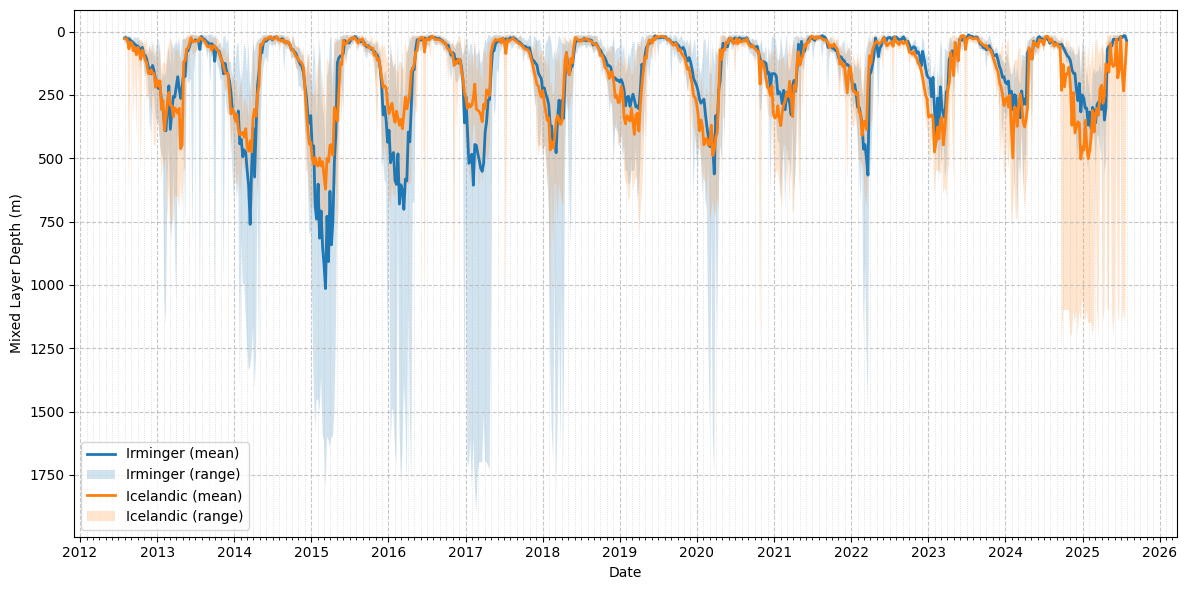

In [151]:
#Plotting 
fig, ax = plt.subplots(figsize=(12, 6))

# Irminger Mea
ax.plot(weekly1["date"], weekly1["MLD_mean"], label="Irminger (mean)", linewidth=2)
ax.fill_between(
    weekly1["date"],
    weekly1["MLD_min"],
    weekly1["MLD_max"],
    alpha=0.2,
    label="Irminger (range)"
)
# Icelandic 
ax.plot(weekly2["date"], weekly2["MLD_mean"], label="Icelandic (mean)", linewidth=2)
ax.fill_between(
    weekly2["date"],
    weekly2["MLD_min"],
    weekly2["MLD_max"],
    alpha=0.2,
    label="Icelandic (range)"
)
# Invert y-axis (MLD increases downward)
ax.invert_yaxis()

# Labels
ax.set_xlabel("Date")
ax.set_ylabel("Mixed Layer Depth (m)")

# Ticks: yearly majors, monthly minors
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_locator(MonthLocator())

# Grid
ax.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.7)
ax.grid(True, which="minor", linestyle=":", linewidth=0.6, alpha=0.5)

# Legend
ax.legend()

fig.tight_layout()
plt.show()

In [152]:
# Creataing MLD Climatology per region

# --- Climatological weekly stats (mean, 25-75% quartiles) ---
clim1 = (
    irminger.groupby("iso_week")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

clim2 = (
    icelandic.groupby("iso_week")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)



def week_to_date(df):
    dates = [dt.date.fromisocalendar(2020, int(w), 1) for w in df["iso_week"]]
    df["date"] = pd.to_datetime(dates)
    return df

clim1 = week_to_date(clim1)
clim2 = week_to_date(clim2)

# Make sure you have a 'month' column (if not already created earlier)
irminger["month"] = irminger["TIME"].dt.month
icelandic["month"] = icelandic["TIME"].dt.month

# --- Climatological monthly stats (mean, 25-75% quartiles) ---
clim1_m = (
    irminger.groupby("month")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

clim2_m = (
    icelandic.groupby("month")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

# Create a fake "climatological" date for mid-month in 2020
clim1_m["date"] = pd.to_datetime(
    dict(year=2020, month=clim1_m["month"], day=15)
)
clim2_m["date"] = pd.to_datetime(
    dict(year=2020, month=clim2_m["month"], day=15)
)
clim1_m.to_parquet('../data/argo/Region/irminger_MLD_Climatology.parquet', index=False)
clim2_m.to_parquet('../data/argo/Region/icelandic_MLD_Climatology.parquet', index=False)


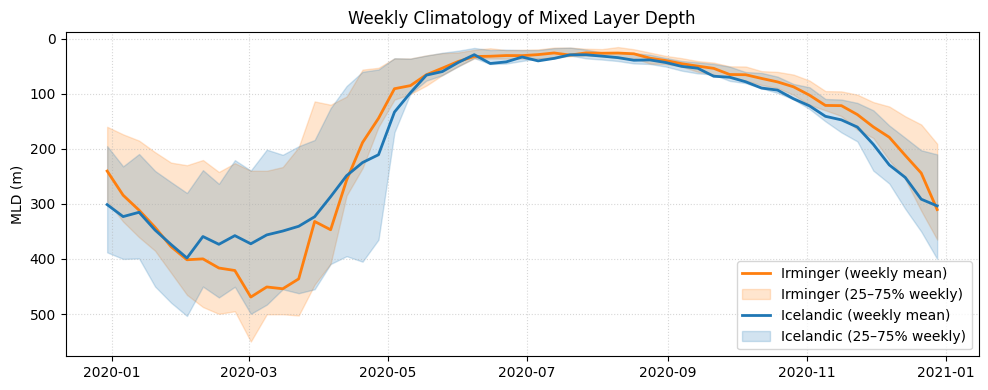

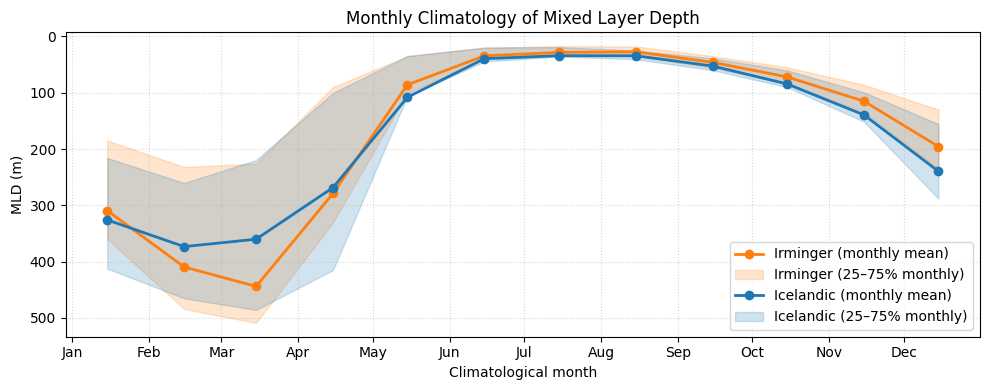

In [155]:
# ===== Weekly climatology =====
fig1, ax1 = plt.subplots(figsize=(10, 4))

# Region 1 — Irminger
ax1.plot(clim1["date"], clim1["MLD_mean"],
         linewidth=2, color="tab:orange",
         label="Irminger (weekly mean)")
ax1.fill_between(clim1["date"],
                 clim1["MLD_p25"], clim1["MLD_p75"],
                 color="tab:orange", alpha=0.2,
                 label="Irminger (25–75% weekly)")

# Region 2 — Icelandic (always blue)
ax1.plot(clim2["date"], clim2["MLD_mean"],
         linewidth=2, color="tab:blue",
         label="Icelandic (weekly mean)")
ax1.fill_between(clim2["date"],
                 clim2["MLD_p25"], clim2["MLD_p75"],
                 color="tab:blue", alpha=0.2,
                 label="Icelandic (25–75% weekly)")

ax1.invert_yaxis()
ax1.set_ylabel("MLD (m)")
ax1.set_title("Weekly Climatology of Mixed Layer Depth")
ax1.grid(True, linestyle=":", alpha=0.5)
ax1.legend()

plt.tight_layout()
plt.show()

# ===== Monthly climatology =====
fig2, ax2 = plt.subplots(figsize=(10, 4))

# Region 1 — Irminger
ax2.plot(clim1_m["date"], clim1_m["MLD_mean"],
         linewidth=2, marker="o", color="tab:orange",
         label="Irminger (monthly mean)")
ax2.fill_between(clim1_m["date"],
                 clim1_m["MLD_p25"], clim1_m["MLD_p75"],
                 color="tab:orange", alpha=0.2,
                 label="Irminger (25–75% monthly)")

# Region 2 — Icelandic (always blue)
ax2.plot(clim2_m["date"], clim2_m["MLD_mean"],
         linewidth=2, marker="o", color="tab:blue",
         label="Icelandic (monthly mean)")
ax2.fill_between(clim2_m["date"],
                 clim2_m["MLD_p25"], clim2_m["MLD_p75"],
                 color="tab:blue", alpha=0.2,
                 label="Icelandic (25–75% monthly)")

ax2.invert_yaxis()
ax2.xaxis.set_major_locator(MonthLocator())
ax2.xaxis.set_major_formatter(DateFormatter("%b"))

ax2.set_xlabel("Climatological month")
ax2.set_ylabel("MLD (m)")
ax2.set_title("Monthly Climatology of Mixed Layer Depth")
ax2.grid(True, linestyle=":", alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

## BGC-Chlorophyll Analysis
Here we conduct Analysis on BGC-CHLA analysis

In [223]:
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
df = pl.read_parquet("../data/argo/Profiles/argo_sprof_flat_pd.parquet")

# QC Filtering on CHLA_ADJUSTED data
df = df.filter(pl.col('CHLA_ADJUSTED_QC').is_in([1,2]))  # Keep only good and probably good data

# Filtering Negative and zero CHLA values
df = df.filter(pl.col('CHLA_ADJUSTED') > 0)

# Filtering Date after 2020-01-01
#df = df.filter(pl.col('TIME') > dt.datetime(2020, 1, 1))

# Adjusting CHLA values reducing by a a factor of 4
#df = df.with_columns(
#    (pl.col('CHLA_ADJUSTED') / 4).alias('CHLA_ADJUSTED')
#)

#Filtering out extreme CHLA values above 10 mg/m3
df = df.filter(
    pl.col("CHLA_ADJUSTED") <= 15
)

# Filtering Irminger and 2
df = df.filter(pl.col('region') != 'Other')


In [225]:
# Listing headers
print("Listing headers:")
print(df.columns)

Listing headers:
['BBP532', 'BBP532_ADJUSTED', 'BBP532_ADJUSTED_ERROR', 'BBP532_ADJUSTED_QC', 'BBP532_DATA_MODE', 'BBP532_QC', 'BBP700', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_ERROR', 'BBP700_ADJUSTED_QC', 'BBP700_DATA_MODE', 'BBP700_QC', 'BISULFIDE', 'BISULFIDE_ADJUSTED', 'BISULFIDE_ADJUSTED_ERROR', 'BISULFIDE_ADJUSTED_QC', 'BISULFIDE_DATA_MODE', 'BISULFIDE_QC', 'CDOM', 'CDOM_ADJUSTED', 'CDOM_ADJUSTED_ERROR', 'CDOM_ADJUSTED_QC', 'CDOM_DATA_MODE', 'CDOM_QC', 'CHLA', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_ERROR', 'CHLA_ADJUSTED_QC', 'CHLA_DATA_MODE', 'CHLA_QC', 'CONFIG_MISSION_NUMBER', 'CP660', 'CP660_ADJUSTED', 'CP660_ADJUSTED_ERROR', 'CP660_ADJUSTED_QC', 'CP660_DATA_MODE', 'CP660_QC', 'CYCLE_NUMBER', 'DIRECTION', 'DOWNWELLING_PAR', 'DOWNWELLING_PAR_ADJUSTED', 'DOWNWELLING_PAR_ADJUSTED_ERROR', 'DOWNWELLING_PAR_ADJUSTED_QC', 'DOWNWELLING_PAR_DATA_MODE', 'DOWNWELLING_PAR_QC', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE380_ADJUSTED', 'DOWN_IRRADIANCE380_ADJUSTED_ERROR', 'DOWN_IRRADIANCE380_ADJUSTED_QC',

In [226]:

# Printing out platform numbers from dataset
platform_numbers = df['PLATFORM_NUMBER'].unique()
print("Platform numbers in the dataset:")
for platform in platform_numbers:
    print(platform)


Platform numbers in the dataset:
1902304
1902637
1902695
3901581
3901586
3902258
3902260
3902261
3902333
4903365
4903488
4903532
4903659
6900876
6900877
6901180
6901480
6901481
6901482
6901484
6901485
6901486
6901489
6901514
6901515
6901516
6901517
6901518
6901519
6901520
6901523
6901524
6901527
6901646
6901647
6902829
6903579
6904185
6904240
6904241
6990636
7900585
7902223


### Depth Integrating CHL-a

In [227]:
# Creating a depth integrated Chlorophyll column dataframe

# Filtering the between 10m to 500m. (Including, typical euphotic zone depth and avoiding surface [<10m] Tanner et al. 2024)
# Sorting by Depth and profile

float_keys = ["PLATFORM_NUMBER", "CYCLE_NUMBER"]

integrated = (
    df.group_by(float_keys, maintain_order=True)
      .agg(pl.col("CHLA_ADJUSTED").mean().alias("DEPTH_INT_CHL"))
)

integrated_5m = (
    df.filter(pl.col("PRES_ADJUSTED") <= 5)
      .group_by(float_keys, maintain_order=True)
      .agg(pl.col("CHLA_ADJUSTED").mean().alias("DEPTH_INT_CHL_5m"))
)

integrated_10m = (
    df.filter(pl.col("PRES_ADJUSTED") <= 10)
      .group_by(float_keys, maintain_order=True)
      .agg(pl.col("CHLA_ADJUSTED").mean().alias("DEPTH_INT_CHL_10m"))
)

# Integrating CHLA_ADJUSTED Trappazoid Method

#df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER", maintain_order=True).map_groups(lambda g: pl.DataFrame({
#    "PLATFORM_NUMBER": [g["PLATFORM_NUMBER"][0]],
#    "CYCLE_NUMBER": [g["CYCLE_NUMBER"][0]],
#    "DEPTH_INT_CHL": [np.trapezoid(
#                    g["CHLA_ADJUSTED"].to_numpy(),
#                    g["PRES_ADJUSTED"].to_numpy())],}))

# Integrating CHLA_ADJUSTED by just mean CHL



In [228]:
# Furher analysis and plotting can be done based on 'integrated' DataFrame
# Joining CHL replicating to dataframe
df = df.join(integrated, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")
df = df.join(integrated_5m, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")
df = df.join(integrated_10m, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,NITRATE_ADJUSTED_QC,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME,region,DEPTH_INT_CHL,DEPTH_INT_CHL_5m,DEPTH_INT_CHL_10m
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,i64,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns],str,f32,f32,f32
null,null,null,99999,"""""",99999,0.005059,0.005059,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.3632,null,null,0,"""R""",0,7.0591,3.52955,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,19.5,19.5,2.4,1,"""D""",1,35.036427,35.036427,0.01,8,"""D""",8,7.972714,7.972714,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",0.358,null,null
null,null,null,99999,"""""",99999,0.004508,0.004508,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.2724,null,null,0,"""R""",0,9.0593,4.52965,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,20.5,20.5,2.4,1,"""D""",1,35.031666,35.031666,0.01,8,"""D""",8,7.958333,7.958333,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",0.358,null,null
null,null,null,99999,"""""",99999,0.004712,0.004712,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.1816,null,null,0,"""R""",0,7.5555,3.77775,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,22.200001,22.199999,2.4,1,"""D""",1,35.031399,35.031399,0.01,8,"""D""",8,7.9316,7.9316,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",0.358,null,null
null,null,null,99999,"""""",99999,0.004029,0.004029,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.0908,null,null,0,"""R""",0,6.1831,3.09155,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,23.799999,23.799999,2.4,1,"""D""",1,35.032803,35.032803,0.01,8,"""D""",8,7.9226,7.9226,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",0.358,null,null
null,null,null,99999,"""""",99999,0.004137,0.004137,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.2724,null,null,0,"""R""",0,6.7379,3.36895,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,25.5,25.5,2.4,1,"""D""",1,35.036098,35.036098,0.01,8,"""D""",8,7.9181,7.9181,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",0.358,null,null


In [229]:
# Keep one row per profile for climatology
profiles = (
    df
    .select([
        "PLATFORM_NUMBER",
        "CYCLE_NUMBER",
        "DEPTH_INT_CHL",
        "DEPTH_INT_CHL_5m",
        "DEPTH_INT_CHL_10m",
        "TIME",        
        "LATITUDE",
        "LONGITUDE",
        "region",
        "PRES_ADJUSTED",
    ])
    .unique(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"])
    .filter(pl.col("DEPTH_INT_CHL").is_not_null())
)

# Adding month to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.month().alias("month")   # 1–12
)

# Adding Week to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.week().alias("week")   # 1–52
)


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


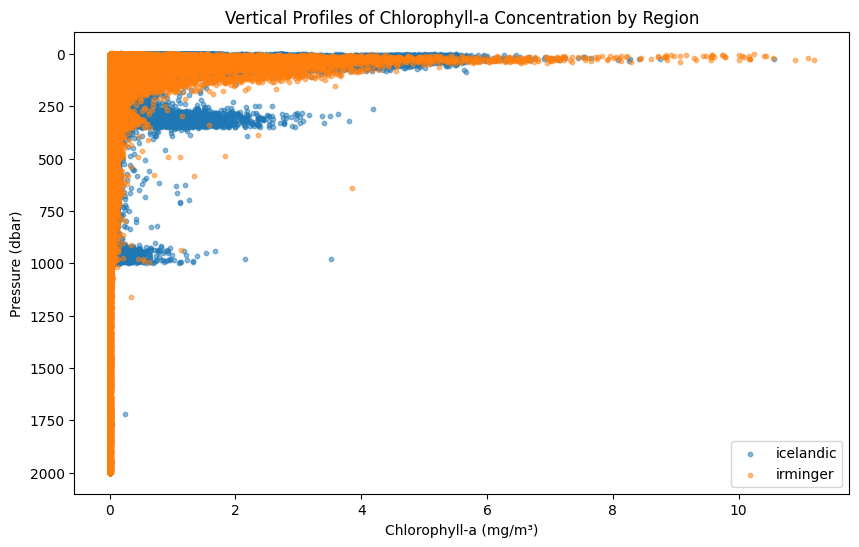

In [230]:
# Plotting scatter plot of vertical profiles of CHLA_ADJUSTED vs Depth per region
fig, ax = plt.subplots(figsize=(10, 6))
for region, group in df.to_pandas().groupby("region"):
    sc = ax.scatter(
        group["CHLA_ADJUSTED"],
        group["PRES_ADJUSTED"],
        s=10,
        alpha=0.5,
        label=region
    )
ax.invert_yaxis()
ax.set_xlabel("Chlorophyll-a (mg/m³)")
ax.set_ylabel("Pressure (dbar)")
ax.set_title("Vertical Profiles of Chlorophyll-a Concentration by Region")
ax.legend()
plt.show()

In [231]:
# Measuring how many profiles have a depth value of 1m or less 
print(f"Total Number of profiles: {df.select(['PLATFORM_NUMBER', 'CYCLE_NUMBER']).unique().height}")
print(f"Number of profiles with a depth value of 1m: {df.filter(pl.col('PRES_ADJUSTED') <= 1).select(['PLATFORM_NUMBER', 'CYCLE_NUMBER']).unique().height}")   

Total Number of profiles: 2910
Number of profiles with a depth value of 1m: 135


### CHL Time series

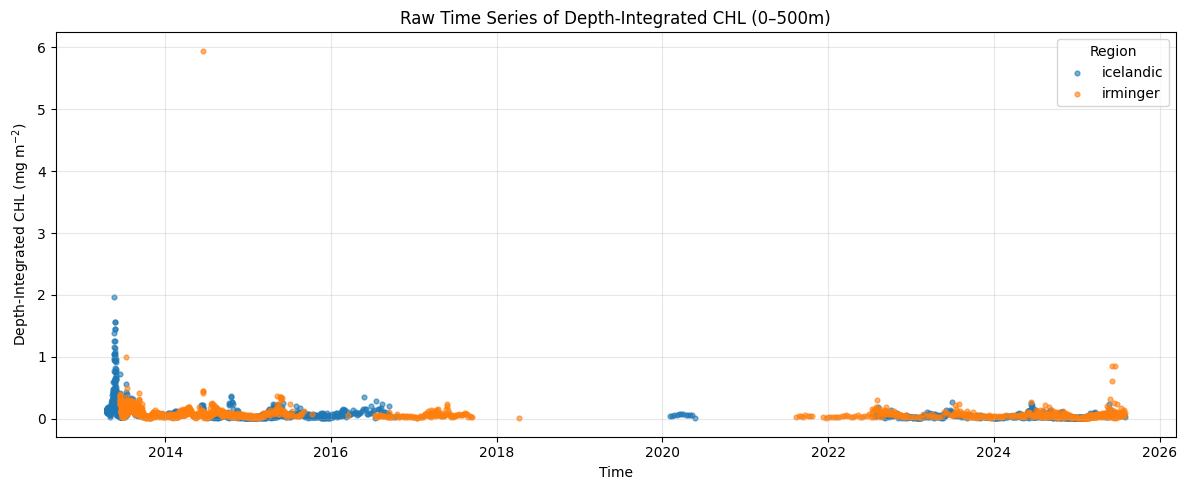

In [232]:
# Plotting a CHL time series per region
profiles_pd = profiles.to_pandas()
profiles_pd["TIME"] = pd.to_datetime(profiles_pd["TIME"])

plt.figure(figsize=(12, 5))

for region_name, group in profiles_pd.groupby("region"):
    plt.scatter(
        group["TIME"],
        group["DEPTH_INT_CHL"],
        s=12,
        alpha=0.6,
        label=region_name
    )

plt.title("Raw Time Series of Depth-Integrated CHL (0–500m)")
plt.xlabel("Time")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()


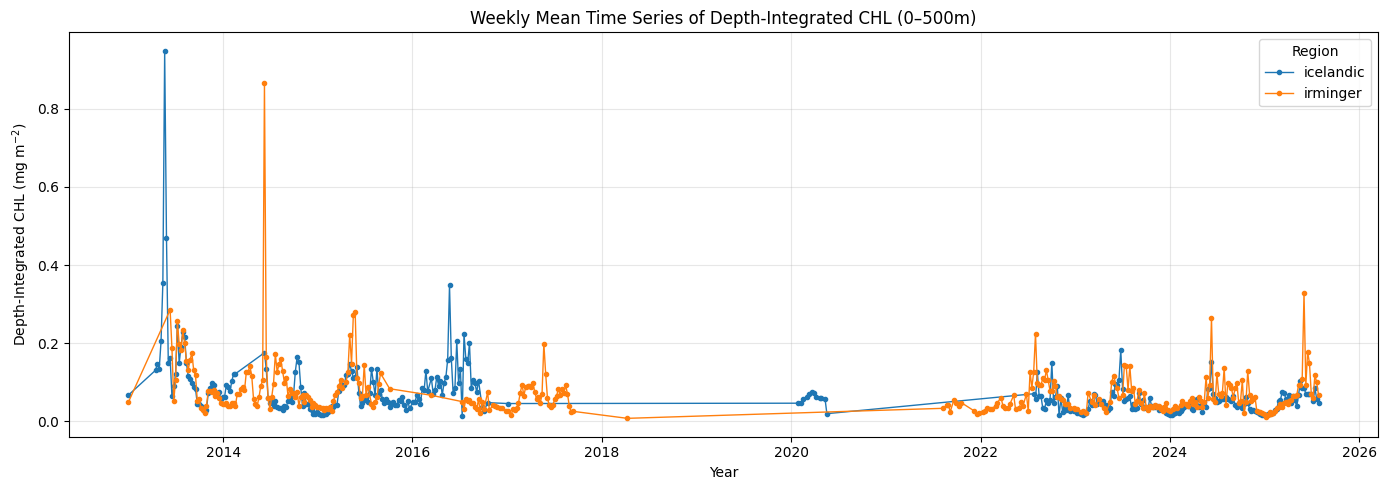

In [233]:
profiles_pd["year"] = profiles_pd["TIME"].dt.year
profiles_pd["week"] = profiles_pd["TIME"].dt.isocalendar().week.astype(int)

weekly_ts = (
    profiles_pd
    .groupby(["region", "year", "week"])
    .agg(
        DEPTH_INT_CHL_mean=("DEPTH_INT_CHL", "mean"),
        DEPTH_INT_CHL_std=("DEPTH_INT_CHL", "std"),
        n_profiles=("DEPTH_INT_CHL", "size"),
    )
    .reset_index()
)

weekly_ts["date"] = pd.to_datetime(
    weekly_ts["year"].astype(str) + "-W" +
    weekly_ts["week"].astype(str) + "-1",
    format="%G-W%V-%u"
)

plt.figure(figsize=(14, 5))

for region_name, group in weekly_ts.groupby("region"):
    group = group.sort_values("date")

    plt.plot(
        group["date"],
        group["DEPTH_INT_CHL_mean"],
        linewidth=1,
        marker="o",
        markersize=3,
        label=region_name
    )

plt.title("Weekly Mean Time Series of Depth-Integrated CHL (0–500m)")
plt.xlabel("Year")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

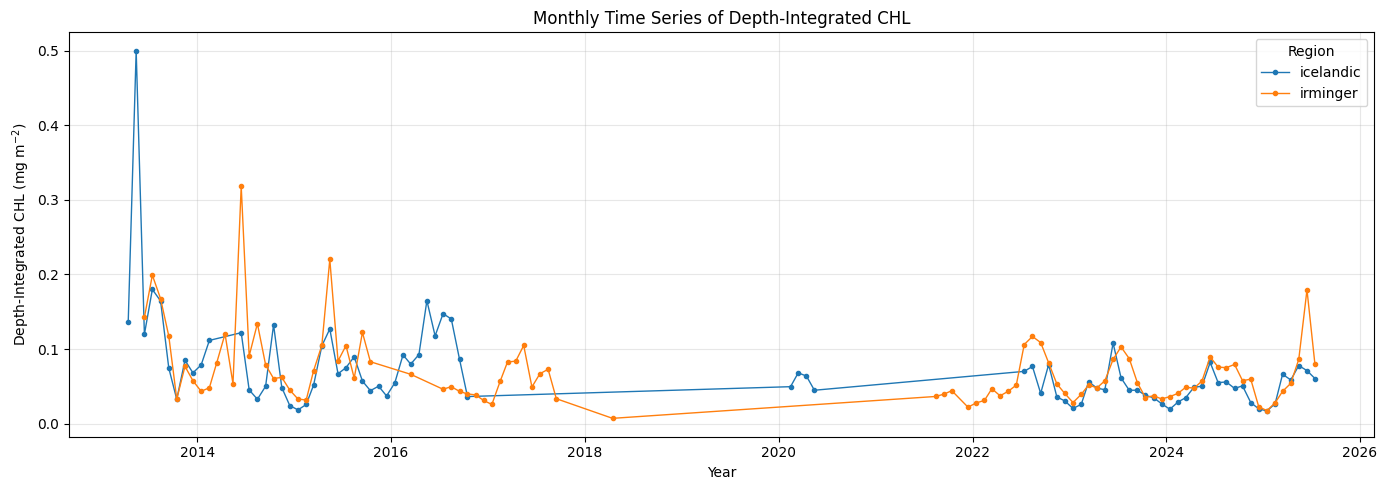

In [234]:
# Extract year and month
profiles_pd["year"] = profiles_pd["TIME"].dt.year
profiles_pd["month"] = profiles_pd["TIME"].dt.month   # calendar month

# Group: region × year × month
monthly_ts = (
    profiles_pd
    .groupby(["region", "year", "month"])
    .agg(
        DEPTH_INT_CHL_mean=("DEPTH_INT_CHL", "mean"),
        DEPTH_INT_CHL_std=("DEPTH_INT_CHL", "std"),
        n_profiles=("DEPTH_INT_CHL", "size"),
    )
    .reset_index()
)

# Build a datetime for the middle of each month
monthly_ts["date"] = pd.to_datetime(
    monthly_ts["year"].astype(str) + "-" +
    monthly_ts["month"].astype(str) + "-15"
)

# Plot
plt.figure(figsize=(14, 5))

for region_name, group in monthly_ts.groupby("region"):
    group = group.sort_values("date")

    plt.plot(
        group["date"],
        group["DEPTH_INT_CHL_mean"],
        linewidth=1,
        marker="o",
        markersize=3,
        label=region_name
    )

    # shading
    #plt.fill_between(
    #    group["date"],
    #    group["DEPTH_INT_CHL_mean"] - group["DEPTH_INT_CHL_std"],
    #    group["DEPTH_INT_CHL_mean"] + group["DEPTH_INT_CHL_std"],
    #    alpha=0.2
    #)

plt.title("Monthly Time Series of Depth-Integrated CHL")
plt.xlabel("Year")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

### Depth Integrate Clamatologies

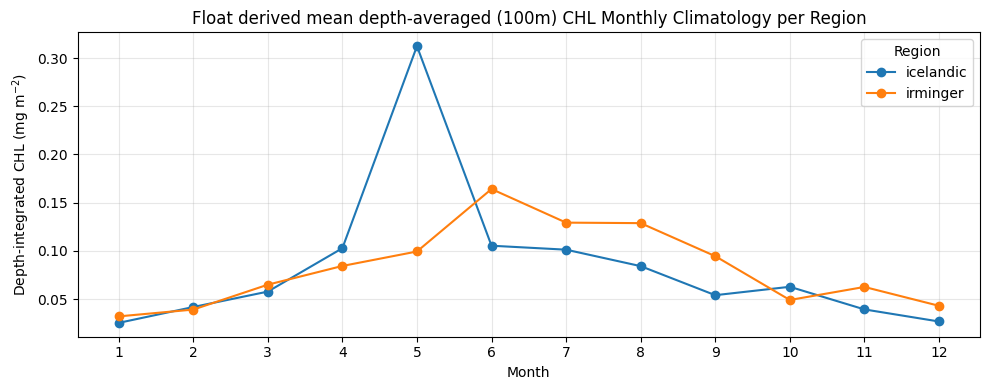

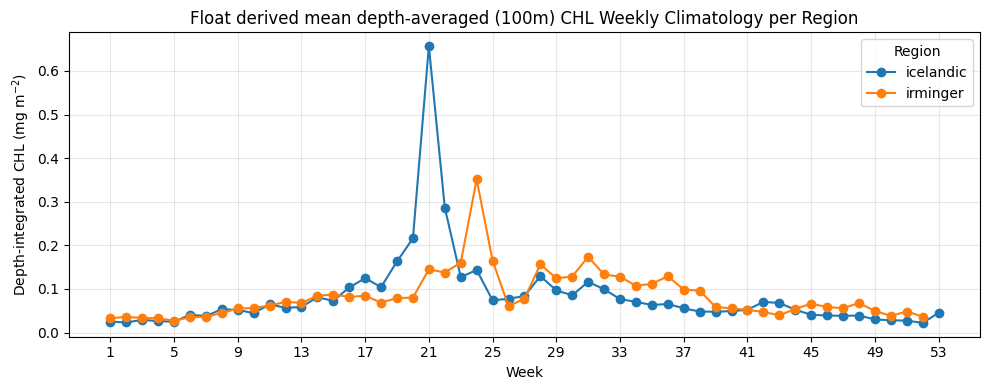

In [235]:
 #Fully integrated

monthly_clim = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)

# Convert to pandas for easy plotting
clim_pd = monthly_clim.to_pandas()
climw_pd = week_clim.to_pandas()

plt.figure(figsize=(10, 4))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["month"],
    #    group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
    #    group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
    #    alpha=0.2,
    #)

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Float derived mean depth-averaged (100m) " \
          "CHL Monthly Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["week"],
    #    group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
    #    group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
    #    alpha=0.2,
    #)
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")   
#limiting y range from 0 to 300 mg m^-2
#plt.ylim(0, 250)
plt.title("Float derived mean depth-averaged (100m) " \
          "CHL Weekly Climatology per Region")
# ax.set_xticks(np.arange(1, 53, 4)) addding every 4 weeks
plt.xticks(ticks=np.arange(1, 54, 4))
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

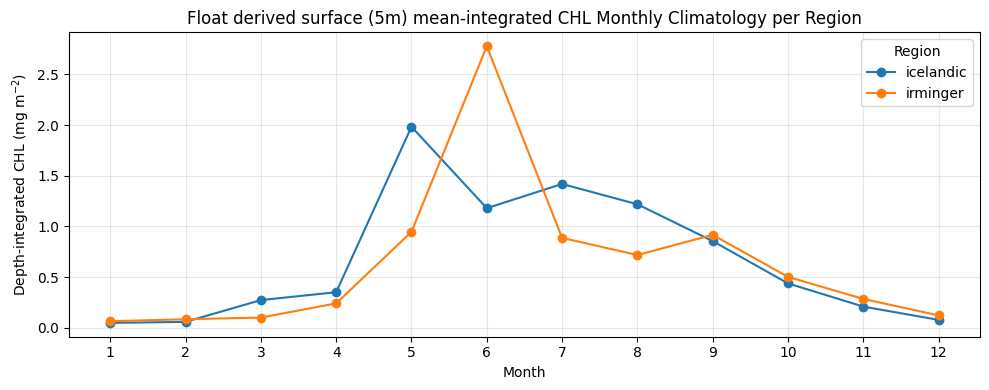

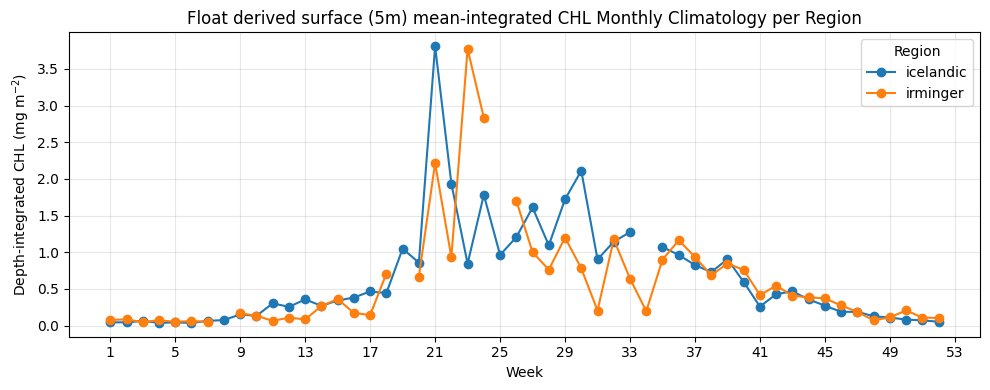

In [236]:
 #5m integrated

monthly_clim = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL_5m").mean().alias("DEPTH_INT_CHL_5m_clim"),
        pl.col("DEPTH_INT_CHL_5m").std().alias("DEPTH_INT_CHL_5m_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL_5m").mean().alias("DEPTH_INT_CHL_5m_clim"),
        pl.col("DEPTH_INT_CHL_5m").std().alias("DEPTH_INT_CHL_5m_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)

# Convert to pandas for easy plotting
clim_pd = monthly_clim.to_pandas()
climw_pd = week_clim.to_pandas()

plt.figure(figsize=(10, 4))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_5m_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["month"],
    #    group["DEPTH_INT_CHL_5m_clim"] - group["DEPTH_INT_CHL_5m_std"],
    #    group["DEPTH_INT_CHL_5m_clim"] + group["DEPTH_INT_CHL_5m_std"],
    #    alpha=0.2,
    #)

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Float derived surface (5m) mean-integrated " \
          "CHL Monthly Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_5m_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["week"],
    #    group["DEPTH_INT_CHL_5m_clim"] - group["DEPTH_INT_CHL_5m_std"],
    #    group["DEPTH_INT_CHL_5m_clim"] + group["DEPTH_INT_CHL_5m_std"],
    #    alpha=0.2,
    #)
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")   
#limiting y range from 0 to 300 mg m^-2
#plt.ylim(0, 250)
plt.title("Float derived surface (5m) mean-integrated " \
          "CHL Monthly Climatology per Region")
# ax.set_xticks(np.arange(1, 53, 4)) addding every 4 weeks
plt.xticks(ticks=np.arange(1, 54, 4))
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

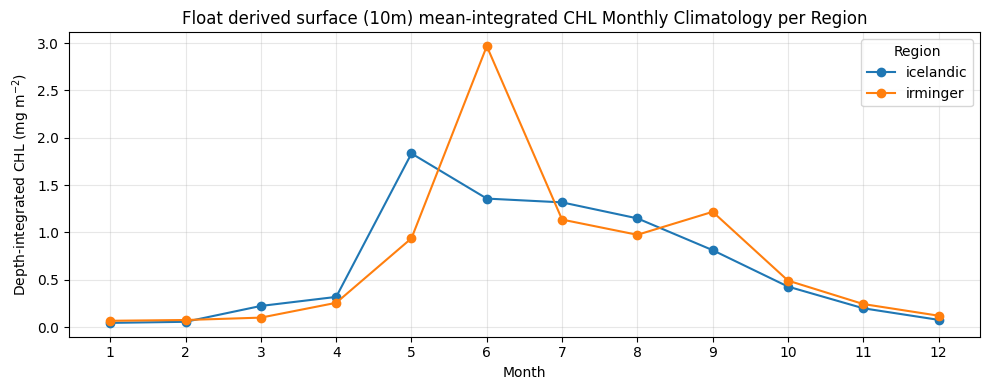

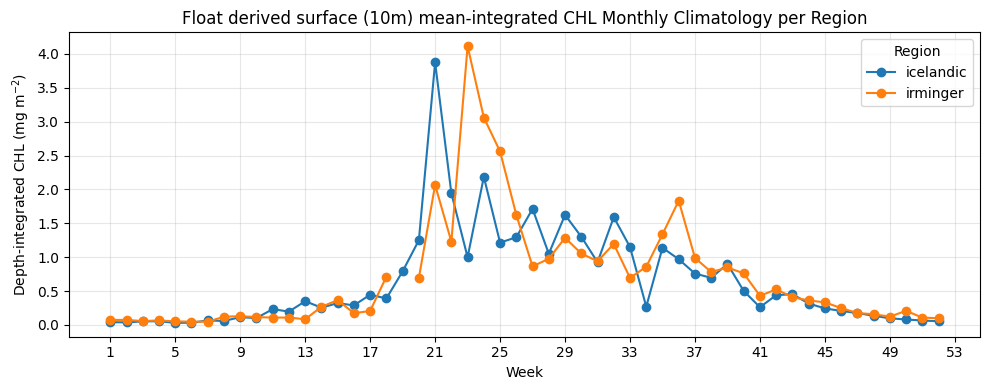

In [237]:
 #10m integrated

monthly_clim = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL_10m").mean().alias("DEPTH_INT_CHL_10m_clim"),
        pl.col("DEPTH_INT_CHL_10m").std().alias("DEPTH_INT_CHL_10m_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL_10m").mean().alias("DEPTH_INT_CHL_10m_clim"),
        pl.col("DEPTH_INT_CHL_10m").std().alias("DEPTH_INT_CHL_10m_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)

# Convert to pandas for easy plotting
clim_pd = monthly_clim.to_pandas()
climw_pd = week_clim.to_pandas()

plt.figure(figsize=(10, 4))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_10m_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["month"],
    #    group["DEPTH_INT_CHL_10m_clim"] - group["DEPTH_INT_CHL_10m_std"],
    #    group["DEPTH_INT_CHL_10m_clim"] + group["DEPTH_INT_CHL_10m_std"],
    #    alpha=0.2,
    #)

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Float derived surface (10m) mean-integrated " \
          "CHL Monthly Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_10m_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["week"],
    #    group["DEPTH_INT_CHL_10m_clim"] - group["DEPTH_INT_CHL_10m_std"],
    #    group["DEPTH_INT_CHL_10m_clim"] + group["DEPTH_INT_CHL_10m_std"],
    #    alpha=0.2,
    #)
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")   
#limiting y range from 0 to 300 mg m^-2
#plt.ylim(0, 250)
plt.title("Float derived surface (10m) mean-integrated " \
          "CHL Monthly Climatology per Region")
# ax.set_xticks(np.arange(1, 53, 4)) addding every 4 weeks
plt.xticks(ticks=np.arange(1, 54, 4))
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

### Depth specefic timeseries



In [238]:

BIN = 20
ZMAX = 100

# (re)create per-profile-per-bin table (if you already have profiles_z, just ensure BIN=20)
df_binned = (
    df.filter((pl.col("PRES_ADJUSTED") >= 0) & (pl.col("PRES_ADJUSTED") <= ZMAX))
      .with_columns((pl.col("PRES_ADJUSTED") // BIN * BIN).cast(pl.Int32).alias("zbin"))
      .filter(pl.col("zbin") < ZMAX)
)

profiles_z = (
    df_binned
    .group_by(["PLATFORM_NUMBER","CYCLE_NUMBER","region","zbin"], maintain_order=True)
    .agg([
        pl.col("CHLA_ADJUSTED").mean().alias("CHL_bin"),
        pl.col("TIME").first().alias("TIME"),
    ])
    .filter(pl.col("CHL_bin").is_not_null())
    .with_columns(pl.col("TIME").dt.month().alias("month"))
)

monthly_clim_z = (
    profiles_z
    .group_by(["region","zbin","month"])
    .agg([
        pl.col("CHL_bin").mean().alias("CHL_clim"),
        pl.col("CHL_bin").std().alias("CHL_std"),
        pl.len().alias("n_profiles"),
    ])
    .sort(["zbin","month","region"])
)

clim_pd = monthly_clim_z.to_pandas()

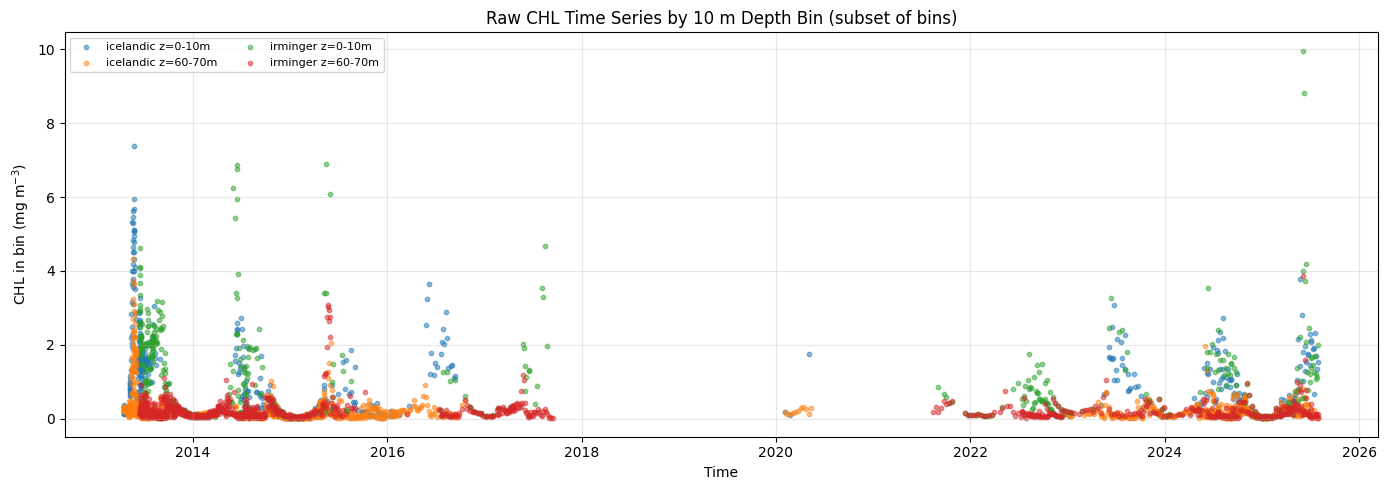

In [239]:
pz = profiles_z.to_pandas()
pz["TIME"] = pd.to_datetime(pz["TIME"])

bins_to_plot = [0, 60, 100]  # meters (bin start)

plt.figure(figsize=(14, 5))
for region_name, g in pz[pz["zbin"].isin(bins_to_plot)].groupby("region"):
    # color/marker by depth bin by looping
    for z, gg in g.groupby("zbin"):
        plt.scatter(gg["TIME"], gg["CHL_bin"], s=10, alpha=0.5, label=f"{region_name} z={z}-{z+10}m")

plt.title("Raw CHL Time Series by 10 m Depth Bin (subset of bins)")
plt.xlabel("Time")
plt.ylabel("CHL in bin (mg m$^{-3}$)")
plt.grid(alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

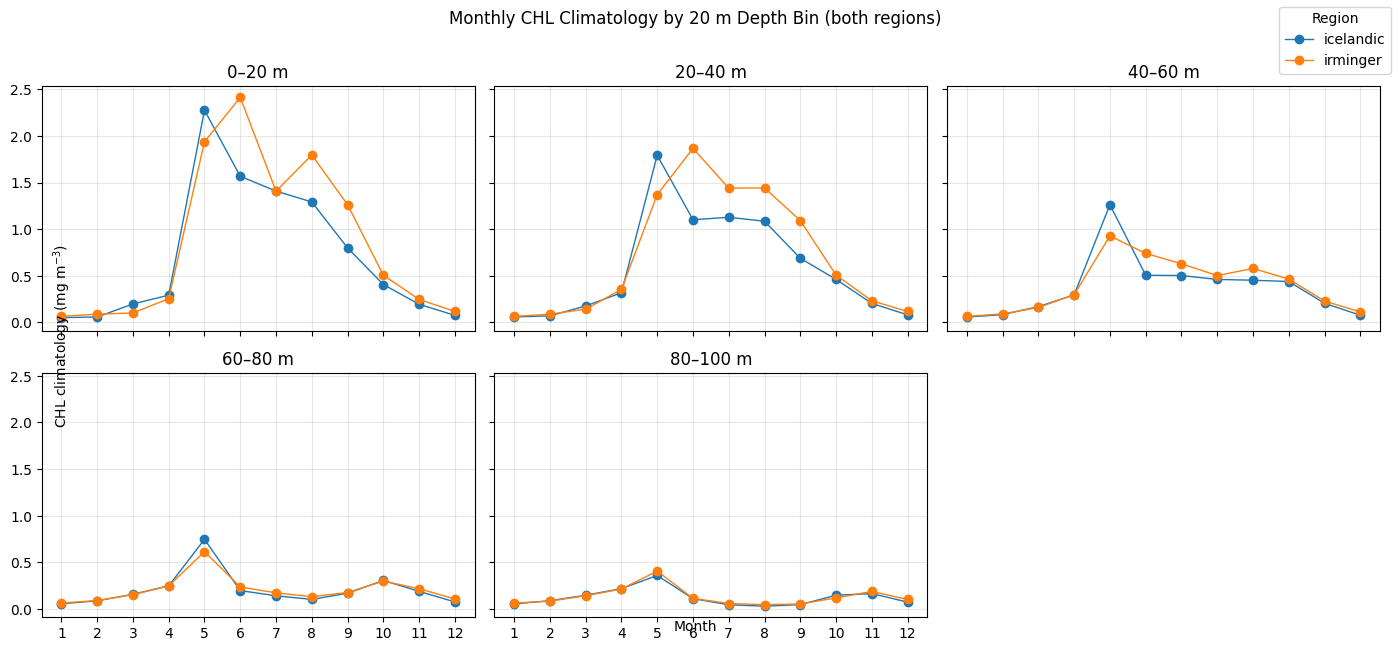

In [240]:
# Depth bins present (e.g., 0..280)
zbins = sorted(clim_pd["zbin"].unique())
regions = sorted(clim_pd["region"].unique())

n = len(zbins)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.2*nrows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, z in enumerate(zbins):
    ax = axes[i]
    g = clim_pd[clim_pd["zbin"] == z].sort_values("month")

    for r in regions:
        gr = g[g["region"] == r].sort_values("month")
        if len(gr) == 0:
            continue
        ax.plot(gr["month"], gr["CHL_clim"], marker="o", linewidth=1, label=r)
        # Optional shading (±1 std)
        # ax.fill_between(gr["month"], gr["CHL_clim"]-gr["CHL_std"], gr["CHL_clim"]+gr["CHL_std"], alpha=0.15)

    ax.set_title(f"{z}–{z+BIN} m")
    ax.set_xticks(range(1, 13))
    ax.grid(alpha=0.3)

# Turn off any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Region", loc="upper right")

fig.suptitle("Monthly CHL Climatology by 20 m Depth Bin (both regions)", y=1.01)
fig.text(0.5, 0.04, "Month", ha="center")
fig.text(0.04, 0.5, "CHL climatology (mg m$^{-3}$)", va="center", rotation="vertical")
plt.tight_layout()
plt.show()

## Euphotic zone integration
Calculating Euphotic zone based Intially based on Morel & Maritonera 2001
Now based on 1% rule

In [157]:
# Getting data

#df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')
df = pl.read_parquet('../data/argo/Profiles/argo_sprof_flat_pd.parquet')

#Printing all column names
print(df.columns)

#Filtering "Other" region
df = df.filter(pl.col('region') != 'Other')

# Irradiance Calculation Function

df = df.filter(pl.col('DOWNWELLING_PAR_QC').is_in(["1","2"]))
#df = df.filter(pl.col('DOWNWELLING_PAR_ADJUSTED_QC').is_in(["1","2"]))  # Keep only good and probably good data



['source_file', 'prof_index', 'level_index', 'PLATFORM_NUMBER', 'CYCLE_NUMBER', 'DIRECTION', 'JULD', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'JULD_QC', 'PRES', 'PRES_QC', 'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PRES_ADJUSTED_ERROR', 'TEMP', 'TEMP_QC', 'TEMP_dPRES', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'TEMP_ADJUSTED_ERROR', 'PSAL', 'PSAL_QC', 'PSAL_dPRES', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_QC', 'PSAL_ADJUSTED_ERROR', 'DOXY', 'DOXY_QC', 'DOXY_dPRES', 'DOXY_ADJUSTED', 'DOXY_ADJUSTED_QC', 'DOXY_ADJUSTED_ERROR', 'CHLA', 'CHLA_QC', 'CHLA_dPRES', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'CHLA_ADJUSTED_ERROR', 'CHLA_FLUORESCENCE', 'CHLA_FLUORESCENCE_QC', 'CHLA_FLUORESCENCE_dPRES', 'CHLA_FLUORESCENCE_ADJUSTED', 'CHLA_FLUORESCENCE_ADJUSTED_QC', 'CHLA_FLUORESCENCE_ADJUSTED_ERROR', 'BBP700', 'BBP700_QC', 'BBP700_dPRES', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC', 'BBP700_ADJUSTED_ERROR', 'CDOM', 'CDOM_QC', 'CDOM_dPRES', 'CDOM_ADJUSTED', 'CDOM_ADJUSTED_QC', 'CDOM_ADJUSTED_ERROR', 'PH_IN_SITU_TOTAL', 'PH_IN_S

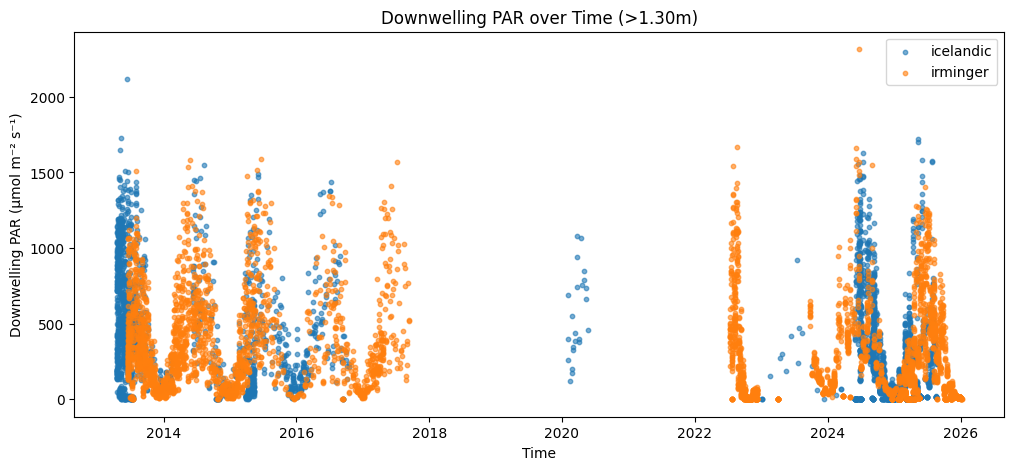

In [158]:
# Plotting all DOWNWELLING_PAR_ADJUSTED values shallower then 1.30 m over time

df_pd = df.to_pandas()

df_pd["TIME"] = pd.to_datetime(df_pd["JULD"], utc=True, errors="coerce")
# or even: df_pd["TIME"] = df_pd["JULD"]  (if it's already datetime)

shallow_pd = df_pd[df_pd["PRES_ADJUSTED"] <= 1.3]

#df_pd = df.to_pandas()
#df_pd["TIME"] = pd.to_datetime(df_pd["TIME"])
#shallow_pd = df_pd[df_pd["PRES_ADJUSTED"] <= 1.3]
plt.figure(figsize=(12, 5))
for region_name, group in shallow_pd.groupby("region"):
    plt.scatter(
        group["TIME"],
        group["DOWNWELLING_PAR"],
        s=10,
        alpha=0.6,
        label=region_name
    )
plt.xlabel("Time")
plt.ylabel("Downwelling PAR (µmol m⁻² s⁻¹)")
plt.title("Downwelling PAR over Time (>1.30m)")
plt.legend()
plt.show()

In [159]:
def compute_zeu(depth, Ed):
    """
    depth : 1D numpy array (m)
    Ed    : 1D numpy array (irradiance)

    Returns Z_eu (m) or NaN
    """
    #  Provides a range around 1m to find reference irradiance
    
    ref_mask = (depth >= 0) & (depth <= 1.30)
    if not np.any(ref_mask):
        return np.nan   

    Ed_ref = np.nanmean(Ed[ref_mask])
    if Ed_ref <= 0:
        return np.nan
    
    # 1% of reference irradiance
    Ed_1pct = 0.01 * Ed_ref 

    # Find where Ed crosses 1% level
    below = Ed <= Ed_1pct
    if not np.any(below):
        return np.nan

    idx = np.argmax(below)

    # Linear interpolation
    if idx == 0:
        return depth[0]

    z1, z2 = depth[idx-1], depth[idx]
    e1, e2 = Ed[idx-1], Ed[idx]

    return z1 + (Ed_1pct - e1) * (z2 - z1) / (e2 - e1)

In [160]:
# Aggregating data sets for Z_eu calculation
profiles = (
    df
    .with_columns(pl.col("JULD").alias("TIME"))
    .filter(
        pl.col("PRES_ADJUSTED").is_not_null()
        & pl.col("DOWNWELLING_PAR").is_not_null()
    )
    .sort(["PLATFORM_NUMBER", "CYCLE_NUMBER", "PRES_ADJUSTED"])
    .group_by(["PLATFORM_NUMBER", "CYCLE_NUMBER"])
    .agg([
        pl.first("TIME").alias("TIME"),
        pl.first("region").alias("region"),
        pl.col("PRES_ADJUSTED").alias("depth"),
        pl.col("DOWNWELLING_PAR").alias("Ed"),
    ])
)


#profiles = (
#    df
#    .filter(
#        (pl.col("DOWNWELLING_PAR_ADJUSTED").is_not_null()))
#    .sort(["PLATFORM_NUMBER", "CYCLE_NUMBER", "PRES_ADJUSTED"])
#    .group_by(["PLATFORM_NUMBER", "CYCLE_NUMBER"])
#    .agg([
#        pl.first("TIME").alias("TIME"),
#        pl.first("region").alias("region"),
#        pl.col("PRES_ADJUSTED").alias("depth"),
#        pl.col("DOWNWELLING_PAR_ADJUSTED").alias("Ed"),
#    ])
#)

In [161]:
# Compute ZEU per profile
zeu_profiles = profiles.with_columns(
    pl.struct(["depth", "Ed"]).map_elements(
        lambda s: compute_zeu(
            np.array(s["depth"]), 
            np.array(s["Ed"])),
        return_dtype=pl.Float64
    ).alias("ZEU_1PCT")
)

In [162]:
ts = zeu_profiles.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])
ts["month"] = ts["TIME"].dt.to_period("M")

monthly_region = (
    ts.groupby(["region", "month"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

monthly_region["month"] = monthly_region["month"].dt.to_timestamp()

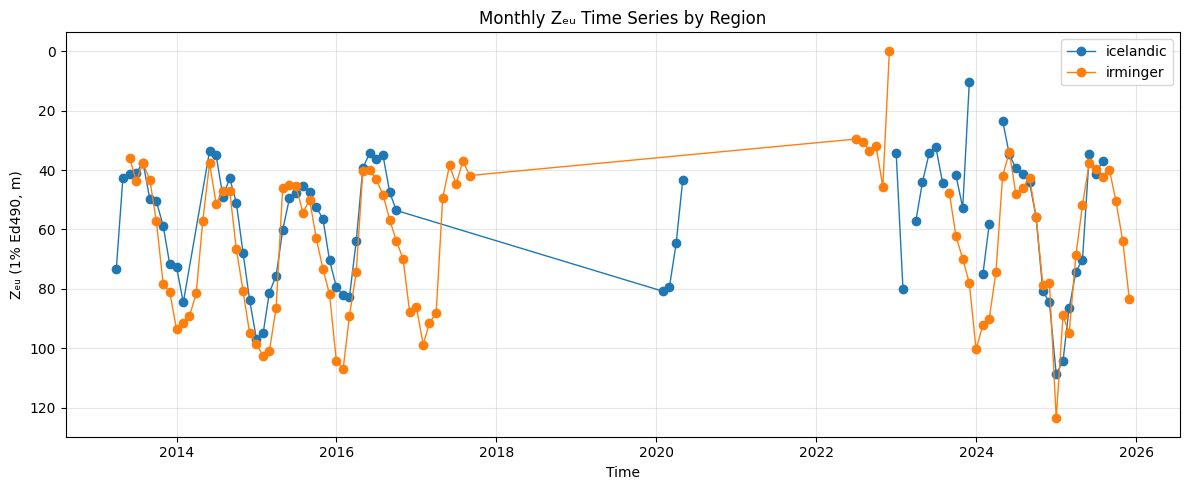

In [163]:

plt.figure(figsize=(12,5))

for region_name, g in monthly_region.groupby("region"):
    g = g.sort_values("month")
    plt.plot(g["month"], g["ZEU_mean"], marker="o", linewidth=1, label=region_name)

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Ed490, m)")
plt.xlabel("Time")
plt.title("Monthly Zₑᵤ Time Series by Region")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [164]:
# Weekly ZEU calculation
ts = zeu_profiles.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])

# ISO week + ISO year (prevents mixing week 1 across different years)
iso = ts["TIME"].dt.isocalendar()
ts["iso_year"] = iso["year"]
ts["iso_week"] = iso["week"]

weekly_region = (
    ts.groupby(["region", "iso_year", "iso_week"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

# Build a representative date for plotting (Monday of each ISO week)
weekly_region["week_start"] = pd.to_datetime(
    weekly_region["iso_year"].astype(str)
    + "-W"
    + weekly_region["iso_week"].astype(str).str.zfill(2)
    + "-1",
    format="%G-W%V-%u"
)

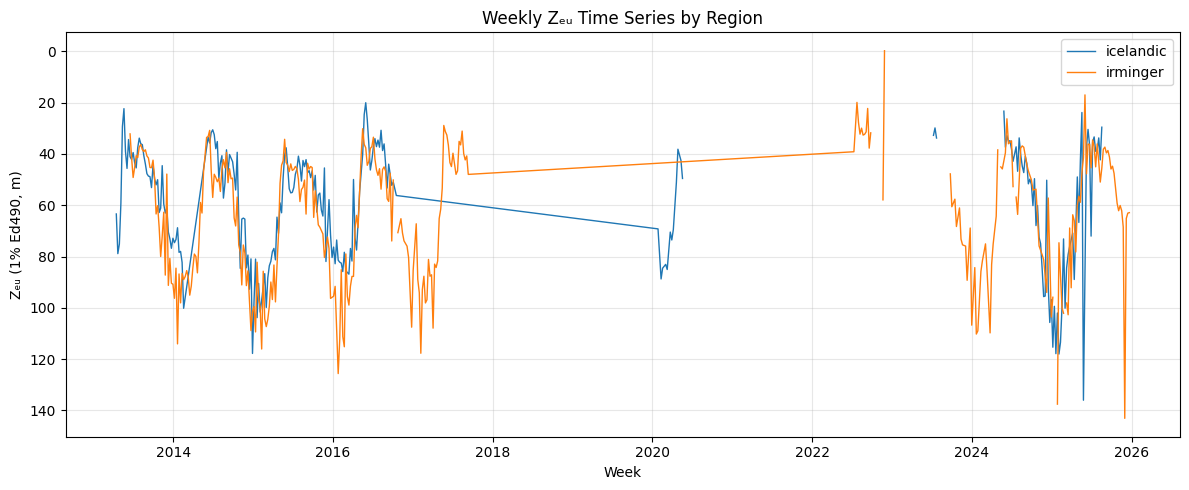

In [165]:
plt.figure(figsize=(12,5))

for region_name, g in weekly_region.groupby("region"):
    g = g.sort_values("week_start")
    plt.plot(g["week_start"], g["ZEU_mean"], linewidth=1, label=region_name)

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Ed490, m)")
plt.xlabel("Week")
plt.title("Weekly Zₑᵤ Time Series by Region")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [166]:
#Cleaning ts for monthly average/weekly average plots
zeu_clean = zeu_profiles.filter(
    (pl.col("ZEU_1PCT").is_not_null()) &
    (pl.col("ZEU_1PCT") > 15) 
)

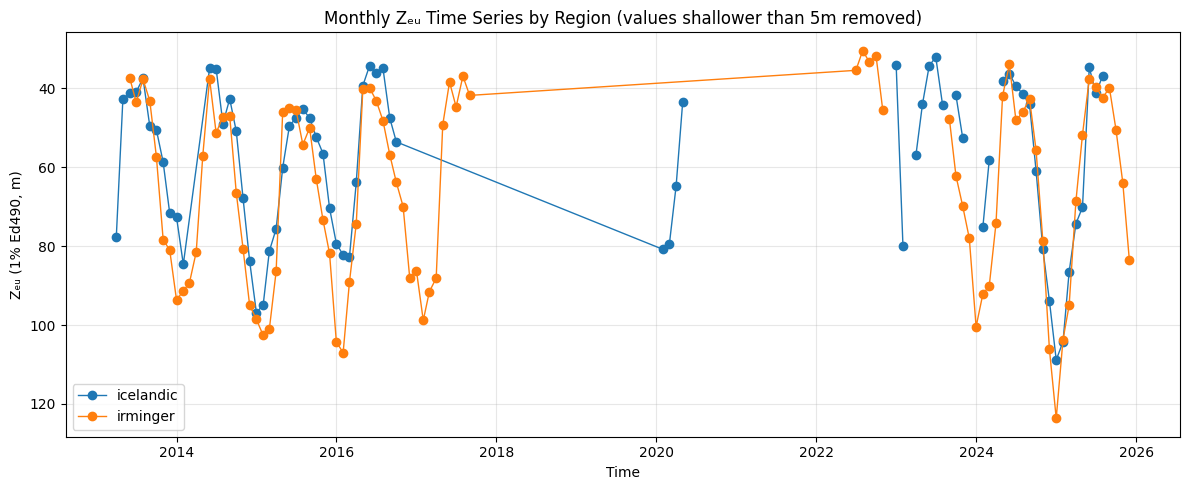

In [167]:
ts = zeu_clean.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])
ts["month"] = ts["TIME"].dt.to_period("M")

monthly_region = (
    ts.groupby(["region", "month"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

monthly_region["month"] = monthly_region["month"].dt.to_timestamp()

plt.figure(figsize=(12,5))

for region_name, g in monthly_region.groupby("region"):
    g = g.sort_values("month")
    plt.plot(g["month"], g["ZEU_mean"], marker="o", linewidth=1, label=region_name)

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Ed490, m)")
plt.xlabel("Time")
plt.title("Monthly Zₑᵤ Time Series by Region (values shallower than 5m removed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


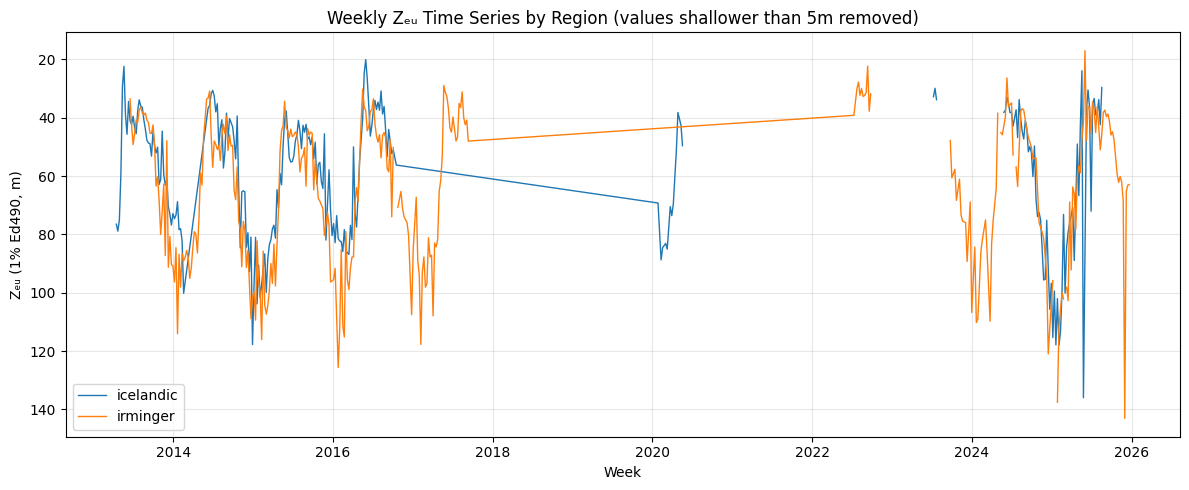

In [168]:
# Weekly ZEU calculation
ts = zeu_clean.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])

# ISO week + ISO year (prevents mixing week 1 across different years)
iso = ts["TIME"].dt.isocalendar()
ts["iso_year"] = iso["year"]
ts["iso_week"] = iso["week"]

weekly_region = (
    ts.groupby(["region", "iso_year", "iso_week"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

# Build a representative date for plotting (Monday of each ISO week)
weekly_region["week_start"] = pd.to_datetime(
    weekly_region["iso_year"].astype(str)
    + "-W"
    + weekly_region["iso_week"].astype(str).str.zfill(2)
    + "-1",
    format="%G-W%V-%u"
)
plt.figure(figsize=(12,5))

for region_name, g in weekly_region.groupby("region"):
    g = g.sort_values("week_start")
    plt.plot(g["week_start"], g["ZEU_mean"], linewidth=1, label=region_name)

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Ed490, m)")
plt.xlabel("Week")
plt.title("Weekly Zₑᵤ Time Series by Region (values shallower than 5m removed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [169]:
#Creating a averaged year long timeseries
ts = zeu_clean.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])

iso = ts["TIME"].dt.isocalendar()
ts["iso_year"] = iso["year"]
ts["iso_week"] = iso["week"]
ts["month"] = ts["TIME"].dt.month

In [170]:
weekly_clim = (
    ts.groupby(["region", "iso_week"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

monthly_clim = (
    ts.groupby(["region", "month"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

# Build a representative date for plotting (Monday of each ISO week) and mid-month date
weekly_clim["week_date"] = pd.to_datetime(
    "2001-W" + weekly_clim["iso_week"].astype(str).str.zfill(2) + "-1",
    format="%G-W%V-%u"
)

monthly_clim["month_date"] = pd.to_datetime(
    "2001-" + monthly_clim["month"].astype(str).str.zfill(2) + "-15"
)

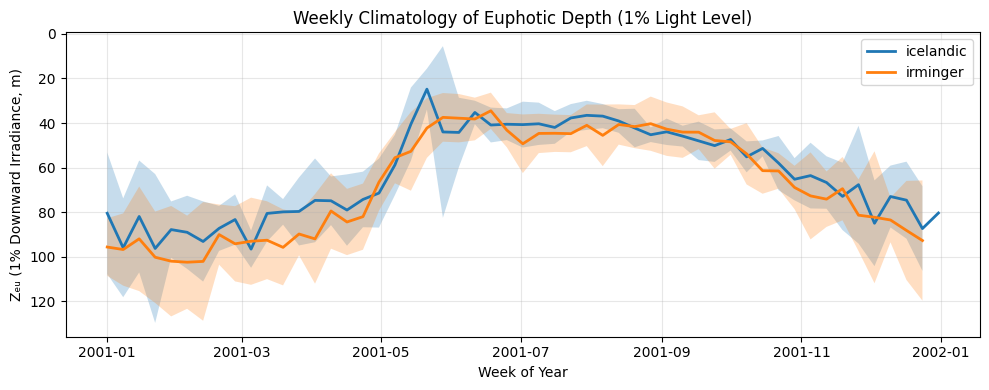

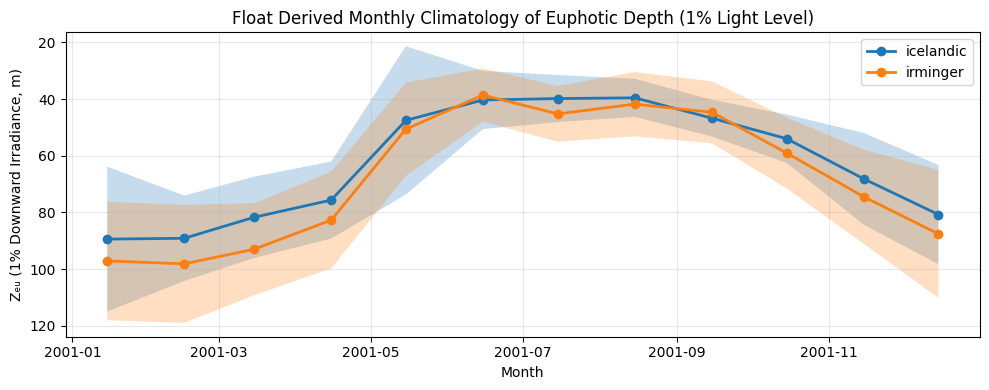

In [171]:
# Weekly Climatology Plotting
plt.figure(figsize=(10,4))

for region_name, g in weekly_clim.groupby("region"):
    g = g.sort_values("iso_week")

    plt.plot(
        g["week_date"],
        g["ZEU_mean"],
        linewidth=2,
        label=region_name
    )

    plt.fill_between(
        g["week_date"],
        g["ZEU_mean"] - g["ZEU_std"],
        g["ZEU_mean"] + g["ZEU_std"],
        alpha=0.25
    )

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Downward Irradiance, m)")
plt.xlabel("Week of Year")
plt.title("Weekly Climatology of Euphotic Depth (1% Light Level)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Monthly Climatology Plotting
plt.figure(figsize=(10,4))

for region_name, g in monthly_clim.groupby("region"):
    g = g.sort_values("month")

    plt.plot(
        g["month_date"],
        g["ZEU_mean"],
        marker="o",
        linewidth=2,
        label=region_name
    )

    plt.fill_between(
        g["month_date"],
        g["ZEU_mean"] - g["ZEU_std"],
        g["ZEU_mean"] + g["ZEU_std"],
        alpha=0.25
    )

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Downward Irradiance, m)")
plt.xlabel("Month")
plt.title("Float Derived Monthly Climatology of Euphotic Depth (1% Light Level)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

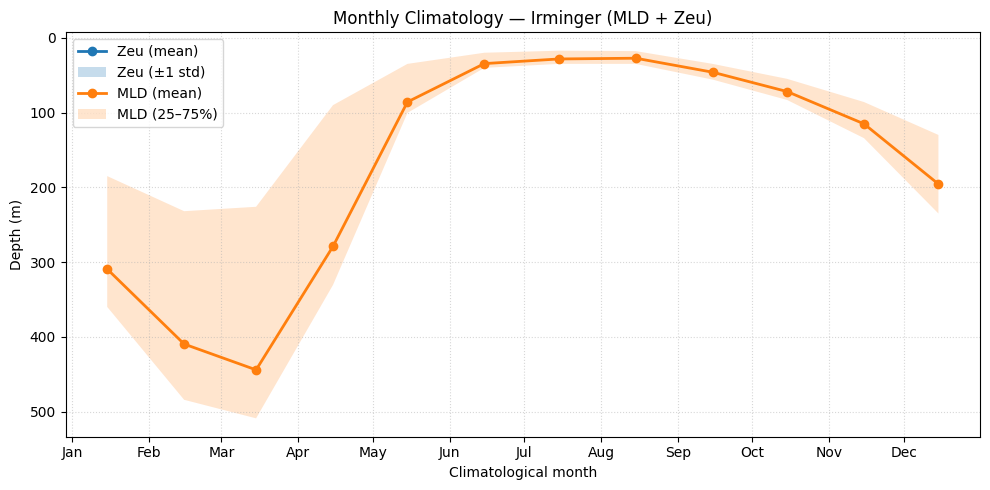

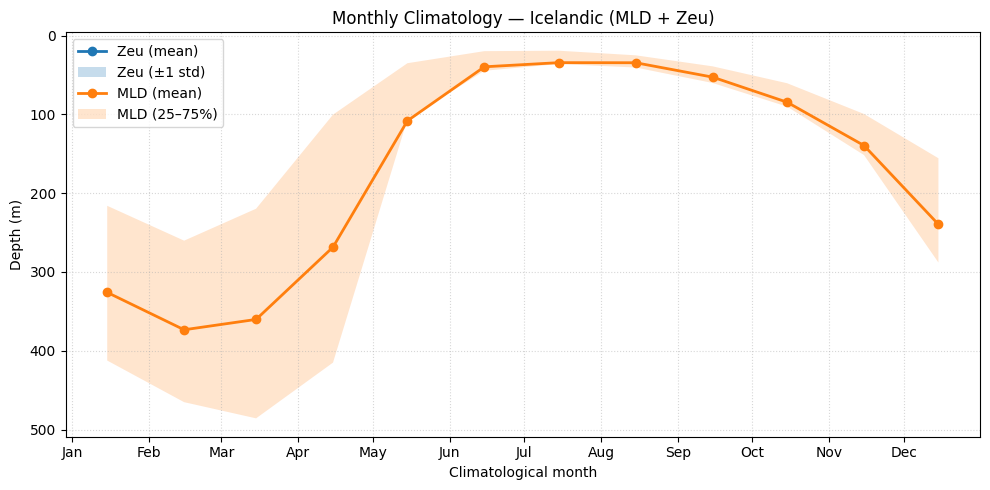

In [172]:

from matplotlib.dates import MonthLocator, DateFormatter

# Helper: map your MLD tables to region names used in monthly_clim
mld_by_region = {
    "Irminger": clim1_m,
    "Icelandic": clim2_m,
}

# If your region labels differ (e.g. "shape1"/"shape2"), just change the keys above.

for region_name, mld_df in mld_by_region.items():
    # --- Zeu subset for this region ---
    zeu_df = monthly_clim[monthly_clim["region"] == region_name].sort_values("month_date")

    fig, ax = plt.subplots(figsize=(10, 5))

    # ===== Zeu =====
    ax.plot(
        zeu_df["month_date"], zeu_df["ZEU_mean"],
        marker="o", linewidth=2, label="Zeu (mean)"
    )
    ax.fill_between(
        zeu_df["month_date"],
        zeu_df["ZEU_mean"] - zeu_df["ZEU_std"],
        zeu_df["ZEU_mean"] + zeu_df["ZEU_std"],
        alpha=0.25, label="Zeu (±1 std)"
    )

    # ===== MLD =====
    mld_df = mld_df.sort_values("date")
    ax.plot(
        mld_df["date"], mld_df["MLD_mean"],
        marker="o", linewidth=2, label="MLD (mean)"
    )
    ax.fill_between(
        mld_df["date"], mld_df["MLD_p25"], mld_df["MLD_p75"],
        alpha=0.20, label="MLD (25–75%)"
    )

    # ===== Formatting =====
    ax.invert_yaxis()
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter("%b"))

    ax.set_xlabel("Climatological month")
    ax.set_ylabel("Depth (m)")
    ax.set_title(f"Monthly Climatology — {region_name} (MLD + Zeu)")
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

## 2020 Gap in data


In [108]:
# Separating floats 3901581 and 4903659

df_3901581 = df.filter(pl.col("PLATFORM_NUMBER") == 3901581)
df_4903659 = df.filter(pl.col("PLATFORM_NUMBER") == 4903659)


ComputeError: cannot compare string with numeric type (i32)

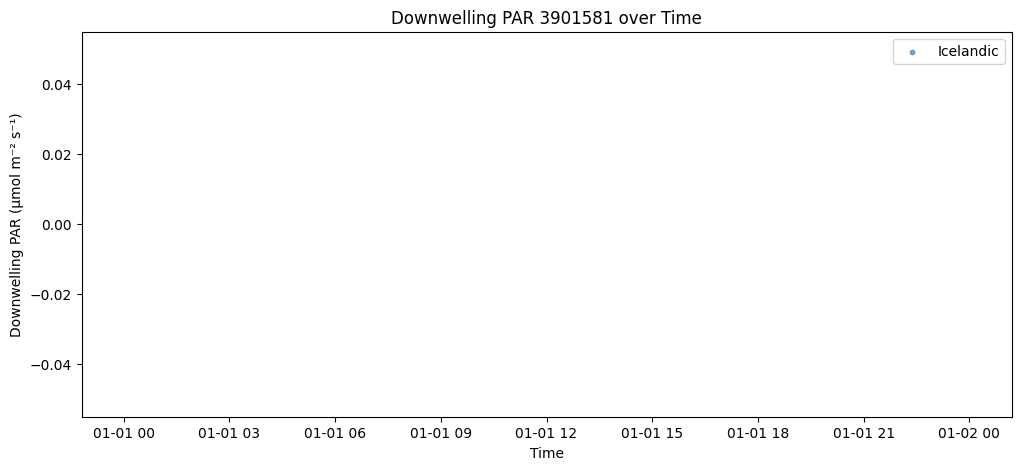

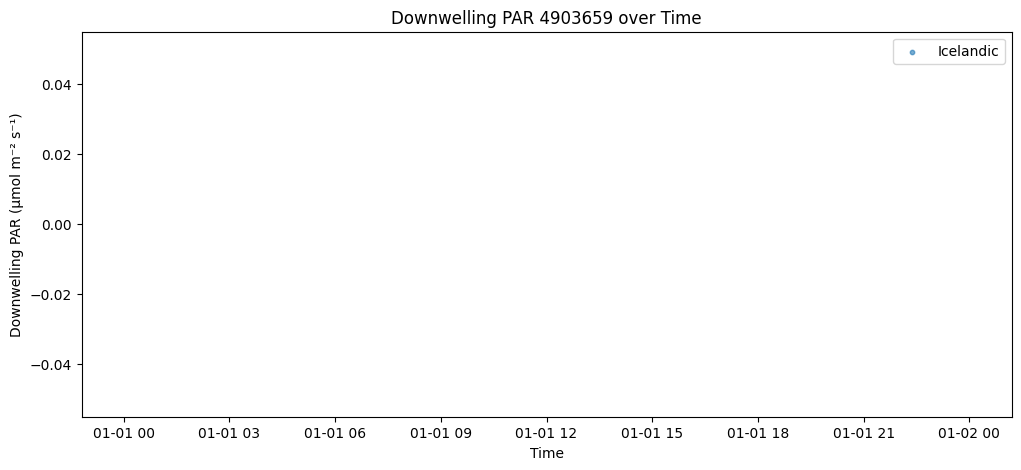

In [ ]:
# Plotting Raw data
df_pd = df_3901581.to_pandas()
df_pd["TIME"] = pd.to_datetime(df_pd["TIME"])
shallow_pd = df_pd[df_pd["PRES_ADJUSTED"] <= 2000]
plt.figure(figsize=(12, 5))
plt.scatter(
    shallow_pd["TIME"],
    shallow_pd["DOWNWELLING_PAR"],
    s=10,
    alpha=0.6,
    label=region_name
)
plt.xlabel("Time")
plt.ylabel("Downwelling PAR (µmol m⁻² s⁻¹)")
plt.title("Downwelling PAR 3901581 over Time")
plt.legend()
plt.show()

df_pd = df_4903659.to_pandas()
df_pd["TIME"] = pd.to_datetime(df_pd["TIME"])
shallow_pd = df_pd[df_pd["PRES_ADJUSTED"] <= 2000]
plt.figure(figsize=(12, 5))
plt.scatter(
    shallow_pd["TIME"],
    shallow_pd["DOWNWELLING_PAR"],
    s=10,
    alpha=0.6,
    label=region_name
)
plt.xlabel("Time")
plt.ylabel("Downwelling PAR (µmol m⁻² s⁻¹)")
plt.title("Downwelling PAR 4903659 over Time")
plt.legend()
plt.show()